# **Generazione di dataset sintetici con diversi livelli di privacy: no privacy, privacy moderata e privacy strong**

Determinareil trade-off tra livello di privacy e l'effettiva utilità del dataset sintetico

In [ ]:
#SALVA TUTTE LE CARTELLE E FILE
!zip -r all_colab_files.zip /content

from google.colab import files
files.download("all_colab_files.zip")

In [2]:
# 1. Install Torch compatibile con Python 3.12
!pip install --quiet torch==2.3.1+cpu torchvision==0.18.1+cpu torchaudio==2.3.1+cpu --index-url https://download.pytorch.org/whl/cpu

# 2. Install SDV recente
!pip install --quiet sdv==1.29.1

# 3. Install CTGAN
!pip install --quiet ctgan==0.11.1

# 4. Install smartnoise
!pip install smartnoise-synth==1.0.5

# 5. Install diffprivlib
!pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 137.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/

In [3]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from diffprivlib.mechanisms import Laplace
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot

from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

## **CARICAMENTO DEL DATASET E SUDDIVISIONE IN TRAIN E HOLDOUT**

In [4]:
def carica_dataset():

    path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
    print("Path to dataset files:", path)

    url = os.path.join(path, "diabetes.csv")
    df = pd.read_csv(url)

    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
    print("Dataset caricato")
    return df

def preprocessa_dataset(df):
    # Le colonne dove 0 è probabile indicatore di dato mancante
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']

    # Sostituisci 0 con NaN in queste colonne specifiche
    df[cols_missing] = df[cols_missing].replace(0, np.nan)

    # Riempimento NaN con mediana colonna
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())

    # Controllo completo e eventuale ulteriore riempimento per NaN residui in tutto il dataframe
    df = df.fillna(df.median())

    #trasforma in int quelle che sono float con nessun decimale davvero
    cols_to_int = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'age', 'outcome']
    for col in cols_to_int:
        if col in df.columns:
            df[col] = df[col].astype(float)
            df[col] = np.rint(df[col]).astype('int64', errors='ignore')

    return df

# Crea le directory se non esistono
os.makedirs("dataset/real", exist_ok=True)
os.makedirs("dataset/synthetic", exist_ok=True)
os.makedirs("models", exist_ok=True)

df = carica_dataset()
df = preprocessa_dataset(df)
df.info()

# Suddivide il dataset in train e holdout
train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['outcome'])

# Salva i due dataset in CSV separati
train_df.to_csv('dataset/real/diabetes_train.csv', index=False)
holdout_df.to_csv('dataset/real/diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

Using Colab cache for faster access to the 'pima-indians-diabetes-database' dataset.
Path to dataset files: /kaggle/input/pima-indians-diabetes-database
Dataset caricato
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        768 non-null    int64  
 1   glucose            768 non-null    int64  
 2   blood_pressure     768 non-null    int64  
 3   skin_thickness     768 non-null    int64  
 4   insulin            768 non-null    int64  
 5   bmi                768 non-null    float64
 6   diabetes_pedigree  768 non-null    float64
 7   age                768 non-null    int64  
 8   outcome            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
Dimensione train: (614, 9)
Dimensione holdout: (154, 9)


## **GENERAZIONE DATI SINTETICI**

### NO PRIVACY

In [5]:
def synthetic_no_privacy(df):
    # Metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    metadata.update_column('outcome', sdtype='categorical')
    metadata.update_column('pregnancies', sdtype='numerical')

    # Modello CTGAN
    model = CTGANSynthesizer(
        metadata,
        epochs=300,
        batch_size=32,
        generator_dim=(64, 64, 64),
        discriminator_dim=(64, 64, 64),
        verbose=True,
        pac=1
    )
    model.fit(df)

    # Genera dati sintetici
    synthetic= model.sample(5000) #num_rows=len(df)

    model.save("models/ctgan_no_privacy.pkl")

    return synthetic, metadata

synthetic_noprivacy, metadata_noprivacy = synthetic_no_privacy(train_df)
synthetic_noprivacy.to_csv('dataset/synthetic/synthetic_no_privacy.csv', index=False)
synthetic_noprivacy.info()

Gen. (-0.84) | Discrim. (-0.24): 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        5000 non-null   int64  
 1   glucose            5000 non-null   int64  
 2   blood_pressure     5000 non-null   int64  
 3   skin_thickness     5000 non-null   int64  
 4   insulin            5000 non-null   int64  
 5   bmi                5000 non-null   float64
 6   diabetes_pedigree  5000 non-null   float64
 7   age                5000 non-null   int64  
 8   outcome            5000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 351.7 KB


### CON PRIVACY

In [6]:
!pip install git+https://github.com/ryan112358/private-pgm.git@01f02f17eba440f4e76c1d06fa5ee9eed0bd2bca

  Cloning https://github.com/ryan112358/private-pgm.git (to revision 01f02f17eba440f4e76c1d06fa5ee9eed0bd2bca) to /tmp/pip-req-build-l6qjf89g
  Running command git clone --filter=blob:none --quiet https://github.com/ryan112358/private-pgm.git /tmp/pip-req-build-l6qjf89g
  Running command git rev-parse -q --verify 'sha^01f02f17eba440f4e76c1d06fa5ee9eed0bd2bca'
  Running command git fetch -q https://github.com/ryan112358/private-pgm.git 01f02f17eba440f4e76c1d06fa5ee9eed0bd2bca
  Running command git checkout -q 01f02f17eba440f4e76c1d06fa5ee9eed0bd2bca
  Resolved https://github.com/ryan112358/private-pgm.git to commit 01f02f17eba440f4e76c1d06fa5ee9eed0bd2bca
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for private-pgm: filename=private_pgm-0.0.1-py3-none-any.whl size=41243 sha256=bc2ff5451f0570a8a578953d0de0f9e897871585b5abb8777a9637664e473fc4
  Stored in directory: /root/.cache/pip/wheels/e5/f5/5d/

In [7]:
#MODELLO MST
from snsynth import Synthesizer
from sdv.metadata import SingleTableMetadata
import os

def synthetic_dp_mst(df, epsilon, model_path):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)

    model = Synthesizer.create(
        synth="mst",
        epsilon=epsilon,
        delta=1e-6,
        verbose=True
    )

    preprocessor_budget = epsilon * 0.2

    model.fit(
        df,
        preprocessor_eps=preprocessor_budget
    )

    df_synt = model.sample(len(df))
    return df_synt, metadata

print("Generazione privacy moderata (ε=6.0)...")
synthetic_mod_mst, metadata_mod_mst = synthetic_dp_mst(train_df, epsilon=6.0, model_path="models/mst_privacy_moderata.pkl")
synthetic_mod_mst.to_csv("dataset/synthetic/synthetic_privacy_moderata_mst.csv", index=False)

print("Generazione privacy forte (ε=2.0)...")
synthetic_strong_mst, metadata_strong_mst = synthetic_dp_mst(train_df, epsilon=2.0, model_path="models/mst_privacy_moderata.pkl")
synthetic_strong_mst.to_csv("dataset/synthetic/synthetic_privacy_strong_mst.csv", index=False)


Generazione privacy moderata (ε=6.0)...
Spent 1.2000000000000002 epsilon on preprocessor, leaving 4.8 for training
Fitting with 467812800000 dimensions
Getting cliques
Estimating marginals
Generazione privacy forte (ε=2.0)...
Spent 0.4 epsilon on preprocessor, leaving 1.6 for training
Fitting with 467812800000 dimensions
Getting cliques
Estimating marginals


In [8]:
#MODELLO PATE-CTGAN
from snsynth import Synthesizer
from sdv.metadata import SingleTableMetadata

def synthetic_dp_patectgan(df, epsilon,model_path):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)

    model = Synthesizer.create(
        synth="patectgan",
        epsilon=epsilon,
        delta=1e-6,
        verbose=True
    )
    preprocessor_budget = epsilon * 0.2

    model.fit(
        df,
        preprocessor_eps=preprocessor_budget
    )

    df_synt = model.sample(len(df))
    return df_synt, metadata

print("Generazione privacy moderata (ε=6.0)...")
synthetic_mod_pate, metadata_mod_pate = synthetic_dp_patectgan(train_df, epsilon=6.0,model_path="models/pate_privacy_moderata.pkl")
synthetic_mod_pate.to_csv("dataset/synthetic/synthetic_privacy_moderata_pate.csv", index=False)

print("Generazione privacy forte (ε=2.0)...")
synthetic_strong_pate, metadata_strong_pate = synthetic_dp_patectgan(train_df, epsilon=2.0,model_path="models/pate_privacy_moderata.pkl")
synthetic_strong_pate.to_csv("dataset/synthetic/synthetic_privacy_strong_pate.csv", index=False)

Generazione privacy moderata (ε=6.0)...
Spent 1.2000000000000002 epsilon on preprocessor, leaving 4.8 for training
using loss cross_entropy and regularization None
eps: 0.138155 	 G: 4.092340 	 D: 0.703745
eps: 0.530670 	 G: 4.186605 	 D: 0.697238
eps: 0.753392 	 G: 4.056261 	 D: 0.696196
eps: 0.925517 	 G: 4.002798 	 D: 0.697377
eps: 1.071366 	 G: 4.086875 	 D: 0.701973
eps: 1.200646 	 G: 3.930414 	 D: 0.699830
eps: 1.317881 	 G: 4.104474 	 D: 0.702705
eps: 1.425776 	 G: 3.904657 	 D: 0.694760
eps: 1.527132 	 G: 3.932205 	 D: 0.702999
eps: 1.622528 	 G: 4.057330 	 D: 0.707922
eps: 1.712677 	 G: 3.994556 	 D: 0.696528
eps: 1.798469 	 G: 3.885454 	 D: 0.708433
eps: 1.881034 	 G: 3.853105 	 D: 0.702971
eps: 1.961034 	 G: 3.911803 	 D: 0.702672
eps: 2.036822 	 G: 3.866256 	 D: 0.714600
eps: 2.111822 	 G: 3.770505 	 D: 0.719174
eps: 2.182732 	 G: 3.874004 	 D: 0.725073
eps: 2.252732 	 G: 3.804290 	 D: 0.720705
eps: 2.321293 	 G: 3.884533 	 D: 0.736800
eps: 2.386293 	 G: 3.784006 	 D: 0.737

In [9]:
#MODELLO DP-CTGAN
from snsynth import Synthesizer
from sdv.metadata import SingleTableMetadata
import os

def synthetic_dp_dpctgan(df, epsilon,model_path):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)

    synth = Synthesizer.create(
        synth="dpctgan",
        epsilon=epsilon,
        verbose=True,
        epochs=800,
        batch_size=100,
        embedding_dim=128,
    )
    synth.fit(
        df,
        preprocessor_eps=epsilon * 0.2
    )

    df_synt = synth.sample(len(df))

    return df_synt, metadata

print("Generazione privacy moderata (ε=6.0)...")
synthetic_mod_dpctgan, metadata_mod_dpctgan = synthetic_dp_dpctgan(train_df, epsilon=6.0, model_path="models/dpctgan_privacy_moderata.pkl")
synthetic_mod_dpctgan.to_csv("dataset/synthetic/synthetic_privacy_moderata_dpctgan.csv", index=False)

print("Generazione privacy forte (ε=2.0)...")
synthetic_strong_dpctgan, metadata_strong_dpctgan = synthetic_dp_dpctgan(train_df, epsilon=2.0, model_path="models/dpctgan_privacy_moderata.pkl")
synthetic_strong_dpctgan.to_csv("dataset/synthetic/synthetic_privacy_strong_dpctgan.csv", index=False)

Generazione privacy moderata (ε=6.0)...
Spent 1.2000000000000002 epsilon on preprocessor, leaving 4.8 for training
Epoch 1, Loss G: 0.6696, Loss D: 1.3865
epsilon is 0.07249736294112627, alpha is 63.0
Epoch 2, Loss G: 0.6675, Loss D: 1.3880
epsilon is 0.4111895520694422, alpha is 27.0
Epoch 3, Loss G: 0.6672, Loss D: 1.3908
epsilon is 0.5867833196464729, alpha is 21.0
Epoch 4, Loss G: 0.6666, Loss D: 1.3897
epsilon is 0.7253563787410949, alpha is 18.0
Epoch 5, Loss G: 0.6665, Loss D: 1.3959
epsilon is 0.8443166940816792, alpha is 16.0
Epoch 6, Loss G: 0.6662, Loss D: 1.3902
epsilon is 0.9514098666672766, alpha is 15.0
Epoch 7, Loss G: 0.6637, Loss D: 1.3931
epsilon is 1.0489252483854026, alpha is 13.0
Epoch 8, Loss G: 0.6696, Loss D: 1.3899
epsilon is 1.138960976690237, alpha is 13.0
Epoch 9, Loss G: 0.6684, Loss D: 1.3909
epsilon is 1.2233345513059082, alpha is 12.0
Epoch 10, Loss G: 0.6646, Loss D: 1.3894
epsilon is 1.3059336361788423, alpha is 12.0
Epoch 11, Loss G: 0.6661, Loss D: 

### **VALUTAZIONE SOMIGLIANZA STATISTICA**

ANALISI QUALITA' DEI DATI SINTETICI

In [10]:
def valuta_qualita_dataset(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI QUALITÀ: {nome} =====")

    # 1) DIAGNOSTICA
    print("\n--- Diagnostic Report ---")
    diagnostic = run_diagnostic(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )

    # 2) QUALITY REPORT
    quality_report = evaluate_quality(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata,
        verbose=False
    )
    print("\n--- Quality Score ---")
    print(quality_report.get_score())

    return diagnostic, quality_report

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA MST", synthetic_mod_mst, metadata_mod_mst),
    ("PRIVACY MODERATA PATE", synthetic_mod_pate, metadata_mod_pate),
    ("PRIVACY MODERATA DP-CTGAN", synthetic_mod_dpctgan, metadata_mod_dpctgan),
    ("PRIVACY STRONG MST", synthetic_strong_mst, metadata_strong_mst),
    ("PRIVACY STRONG PATE", synthetic_strong_pate, metadata_strong_pate),
    ("PRIVACY STRONG DP-CTGAN", synthetic_strong_dpctgan, metadata_strong_dpctgan)
]



diagnostics = {}
quality_reports = {}

for nome, synth_df, meta in datasets_sintetici:
    diag, q_report = valuta_qualita_dataset(df, synth_df, meta, nome)
    diagnostics[nome] = diag
    quality_reports[nome] = q_report



===== ANALISI QUALITÀ: NO PRIVACY =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 793.71it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 234.59it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8958895632118997

===== ANALISI QUALITÀ: PRIVACY MODERATA MST =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 939.79it/s]|
Data Validity Score: 99.69%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 252.29it/s]|
Data Structure Score: 80.0%

Overall Score (Average): 89.85%


--- Quality Score ---
0.8668290565006478

===== ANALISI QUALITÀ: PRIVACY MODERATA PATE =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 1006.71it/s]|
Data Validity Score: 99.64%

(2/2) Evaluating Data Struc

ANALISI SOMIGLIANZA STATISTICA DEI DATI SINTETICI


===== ANALISI SOMIGLIANZA STATISTICA: NO PRIVACY =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           4.7082       0.8631
glucose                          121.6562         121.6612       0.0049
blood_pressure                    72.3867          72.5370       0.1503
skin_thickness                    29.1081          29.0482      -0.0599
insulin                          140.6719         133.4254      -7.2465
bmi                               32.4552          32.2152      -0.2400
diabetes_pedigree                  0.4719           0.4362      -0.0357
age                               33.2409          33.3332       0.0923
outcome                            0.3490           0.4706       0.1216

Confronto MATRICE DI CORRELAZIONE:


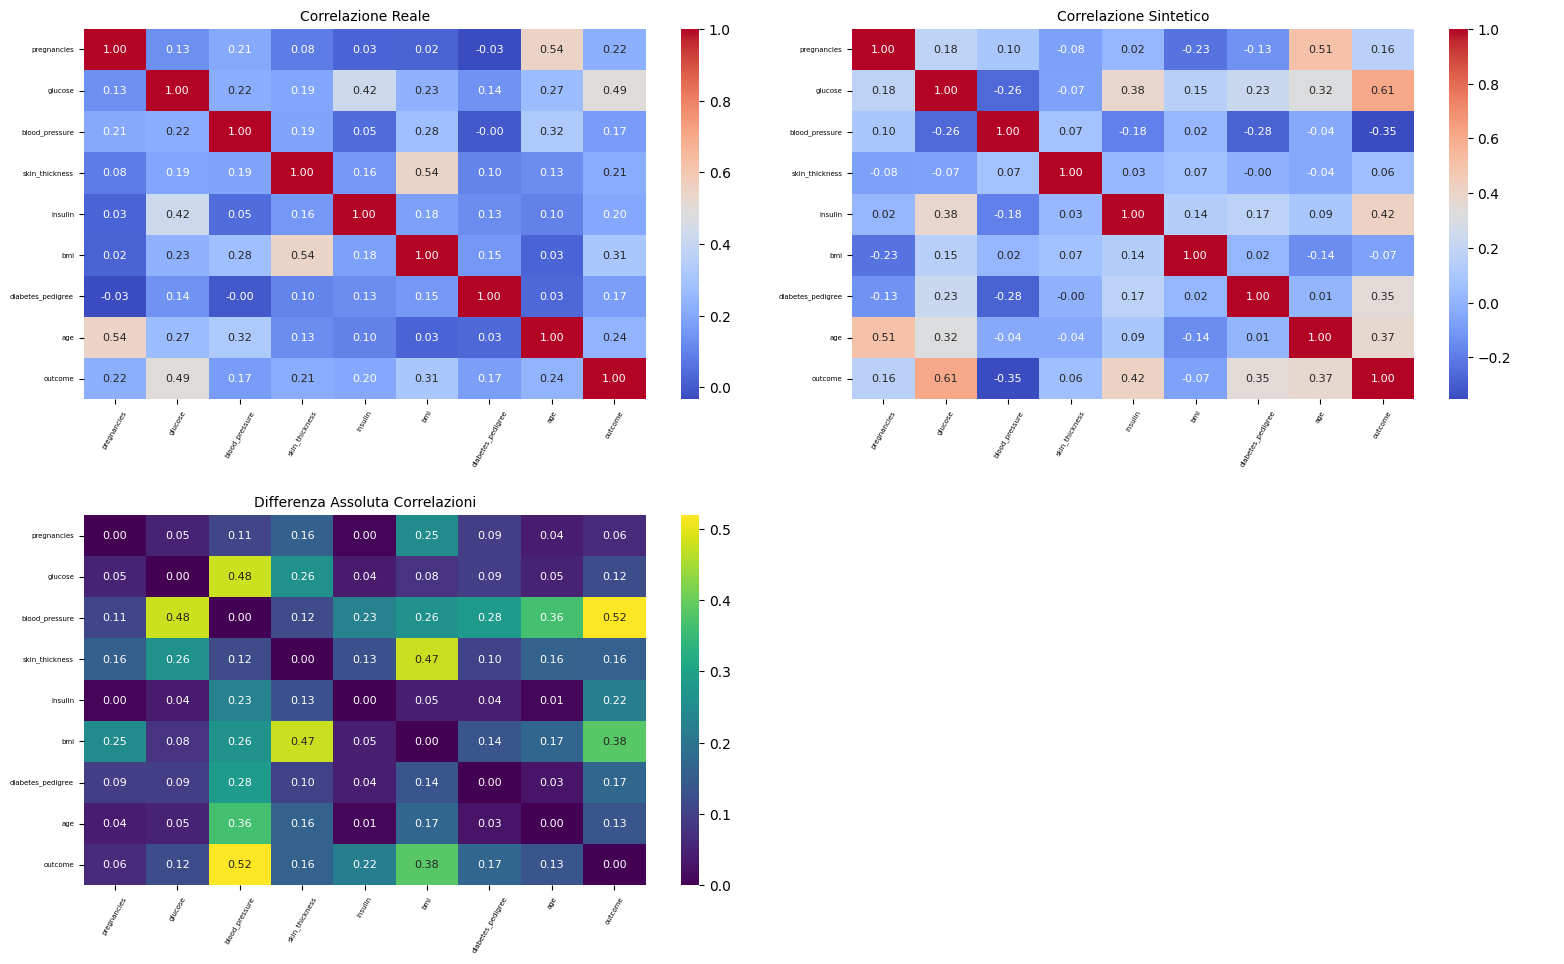

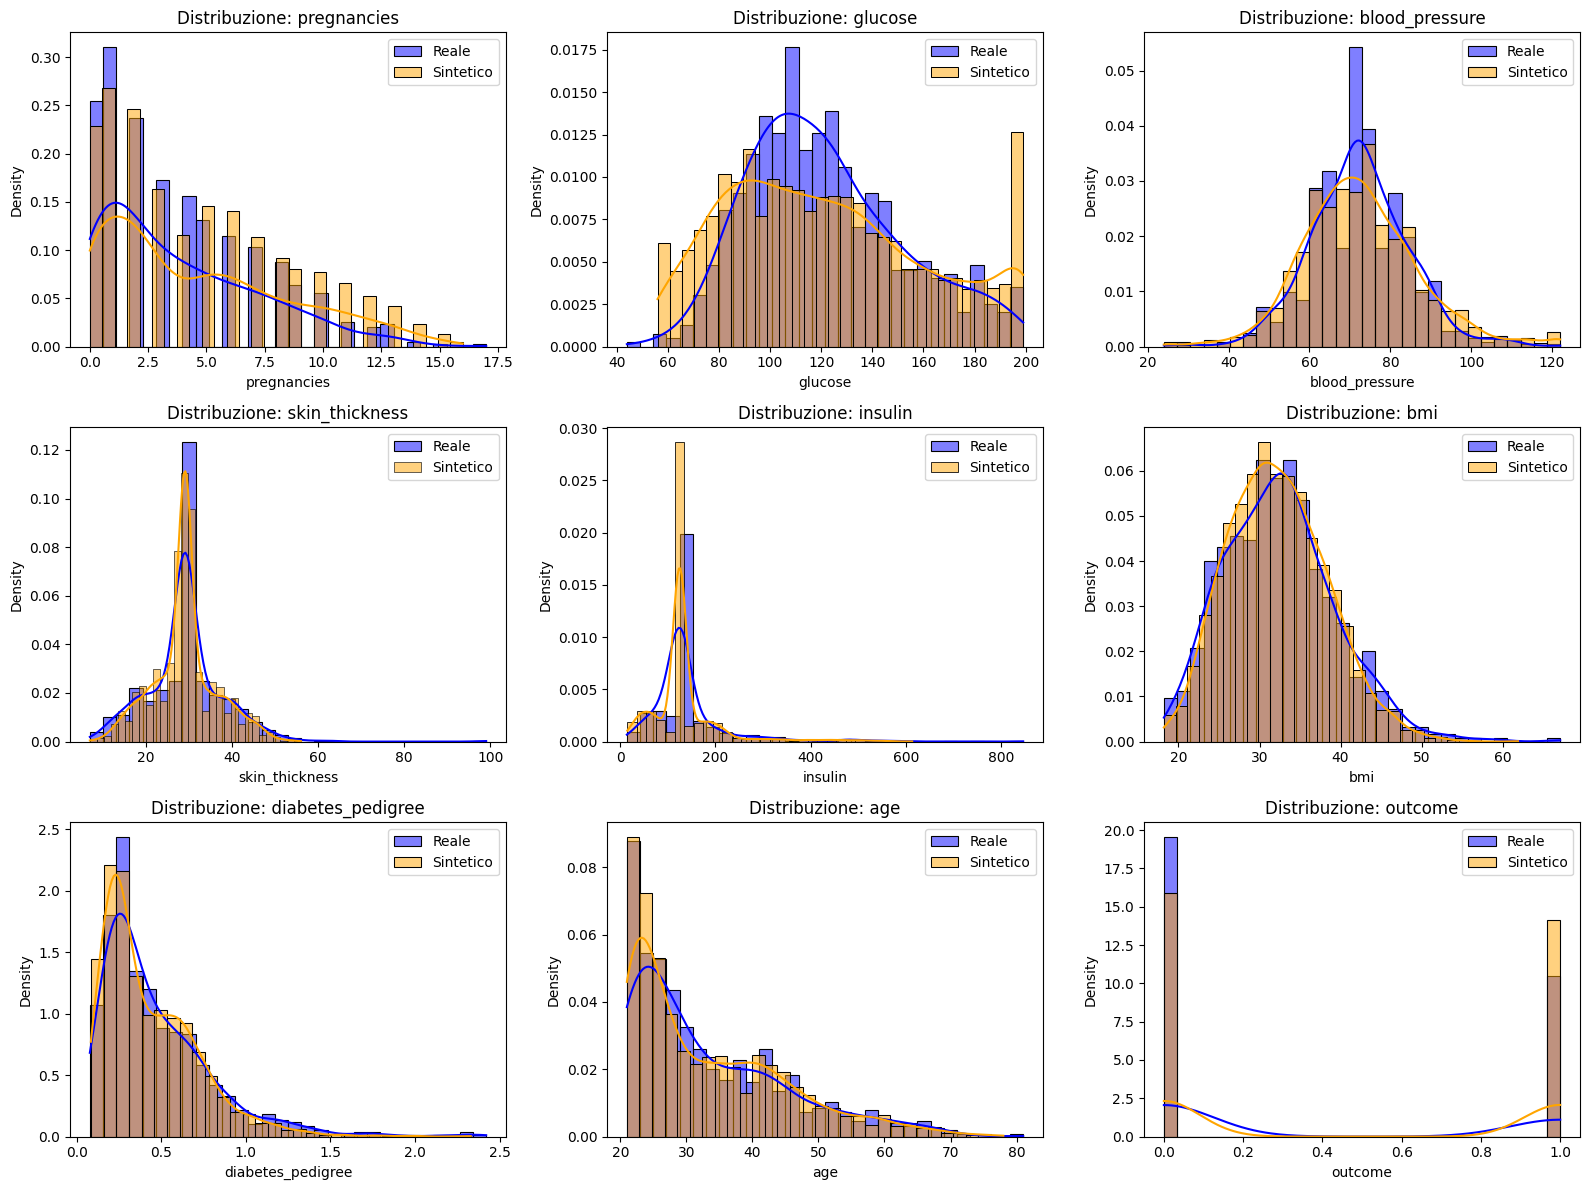


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0000   0.0000   0.0000
glucose                        0.0000   0.9968   0.0000
blood_pressure                 0.0039   0.7556   0.0000
skin_thickness                 0.0034   0.8577   0.0011
insulin                        0.0000   0.0279   0.6142
bmi                            0.3984   0.3615   0.0027
diabetes_pedigree              0.0338   0.0047   0.0141
age                            0.6072   0.8395   0.3836
outcome                        0.0000   0.0000   0.0000

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY MODERATA MST =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           4.0033       0.1582
glucose                          121.6562         125.4691       3.8128
blood_pressure                    72.3867          73.1824       

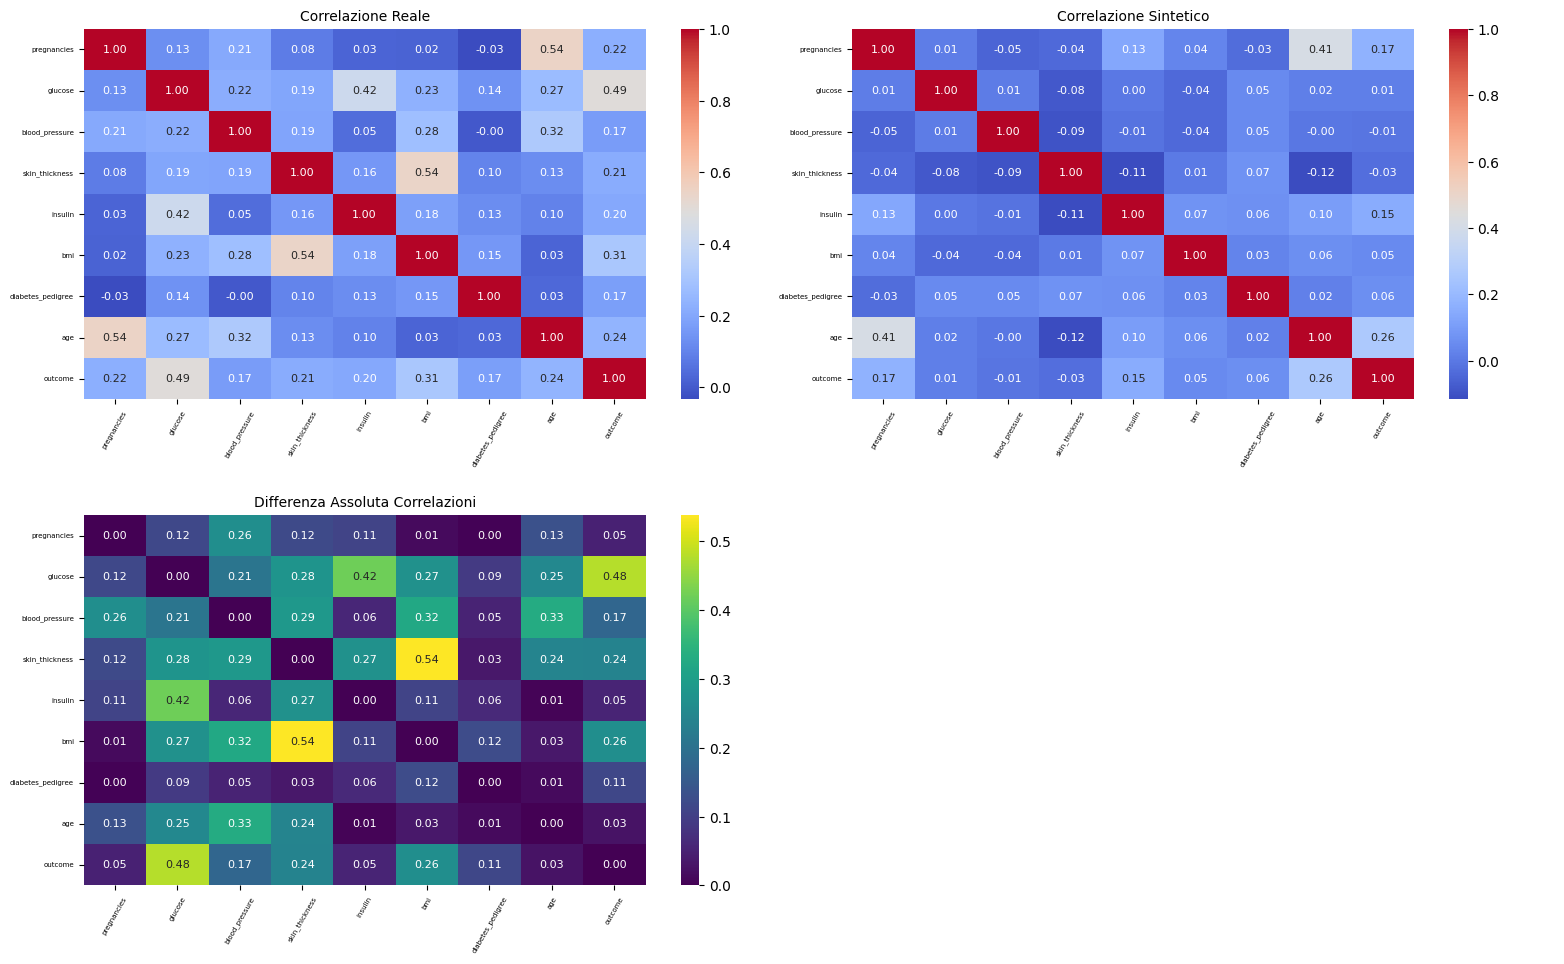

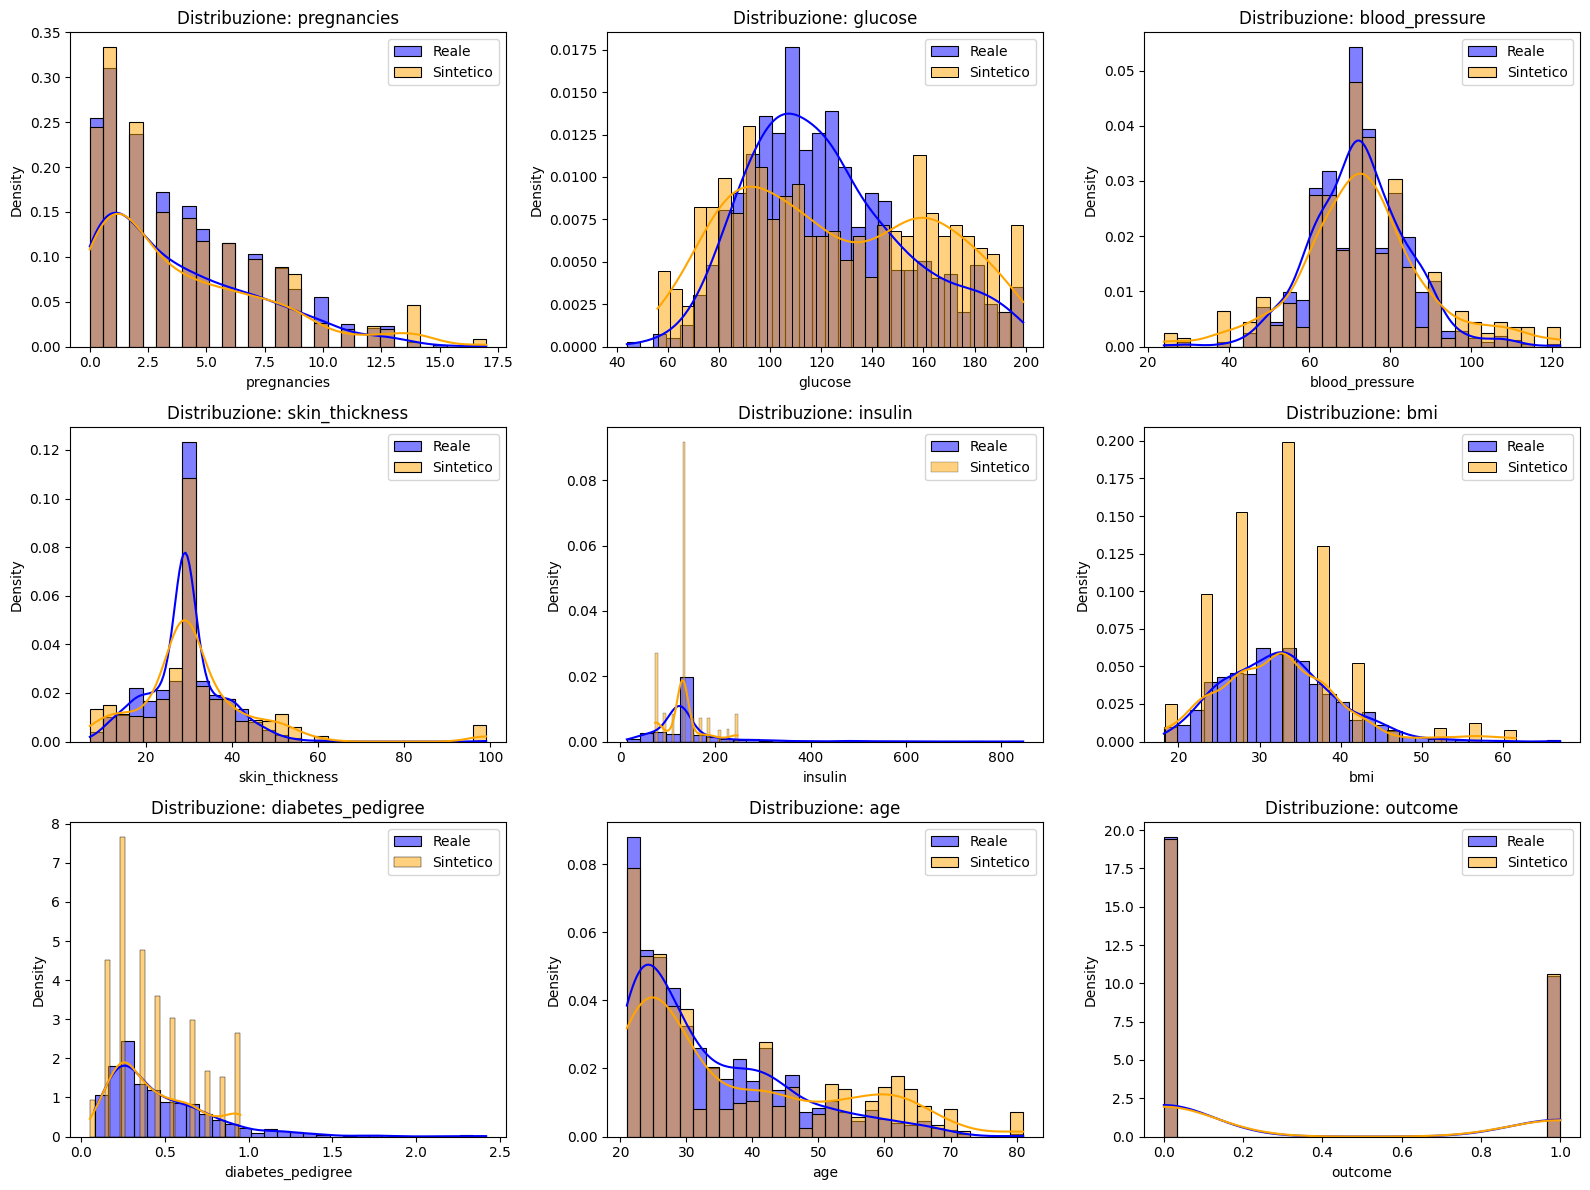


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.9718   0.4109   0.1372
glucose                        0.0000   0.0468   0.0000
blood_pressure                 0.1201   0.3134   0.0000
skin_thickness                 0.0267   0.0015   0.0000
insulin                        0.0000   0.0435   0.0000
bmi                            0.0000   0.6160   0.1986
diabetes_pedigree              0.0000   0.0333   0.0112
age                            0.0000   0.0000   0.0000
outcome                        1.0000   0.8631   0.8630

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY MODERATA PATE =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           3.6417      -0.2034
glucose                          121.6562         120.9772      -0.6791
blood_pressure                    72.3867          72.7785      

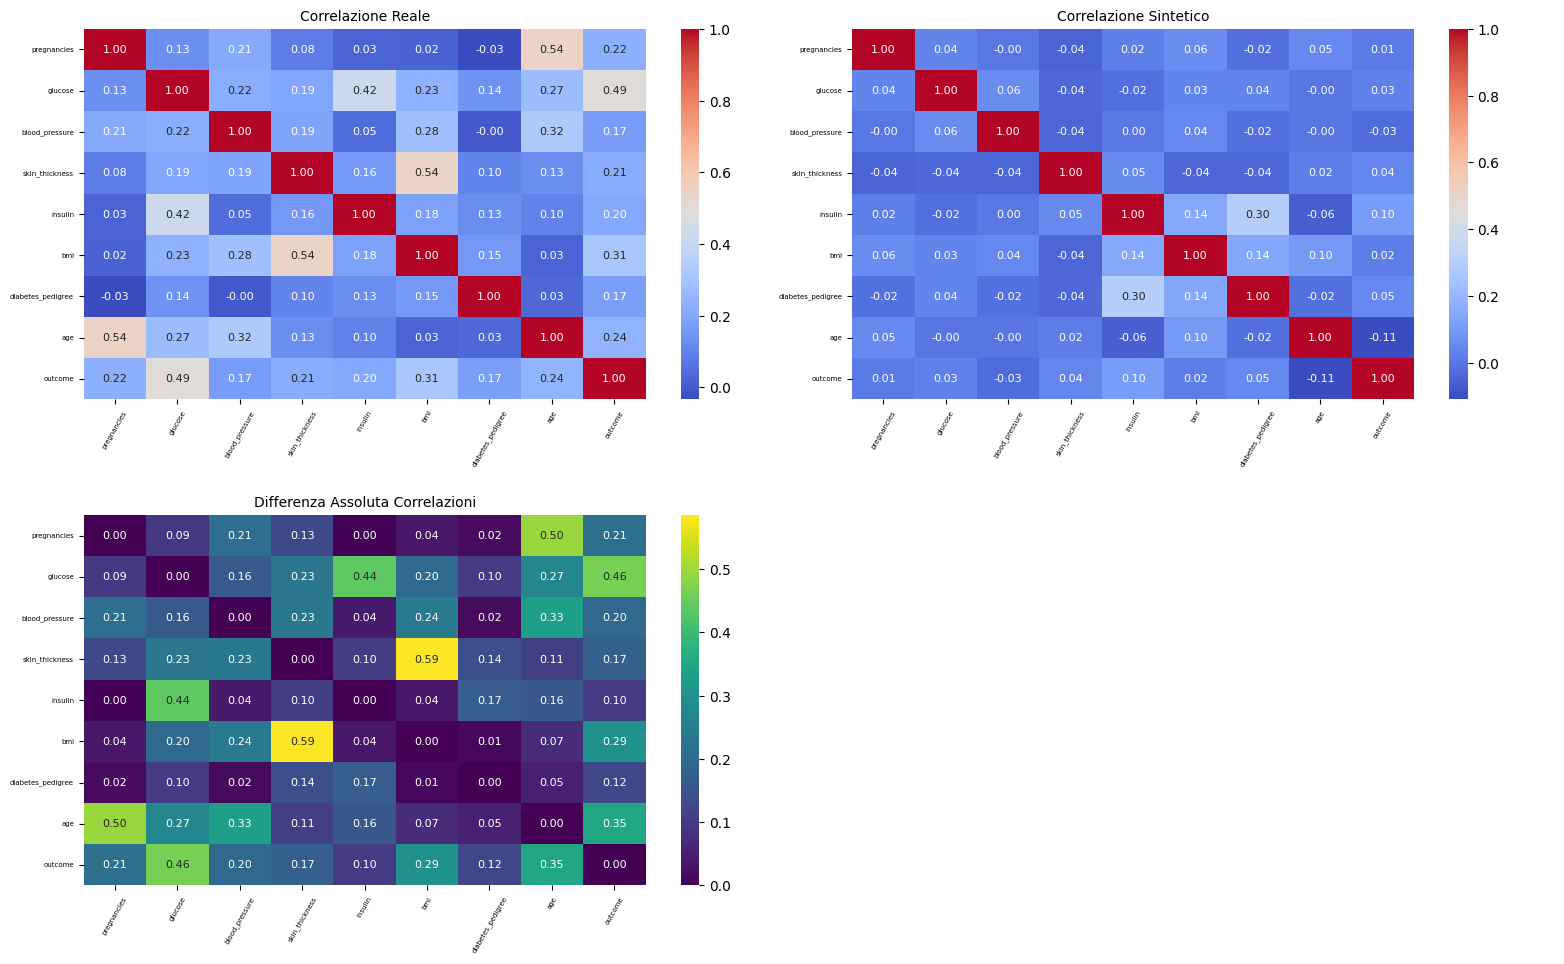

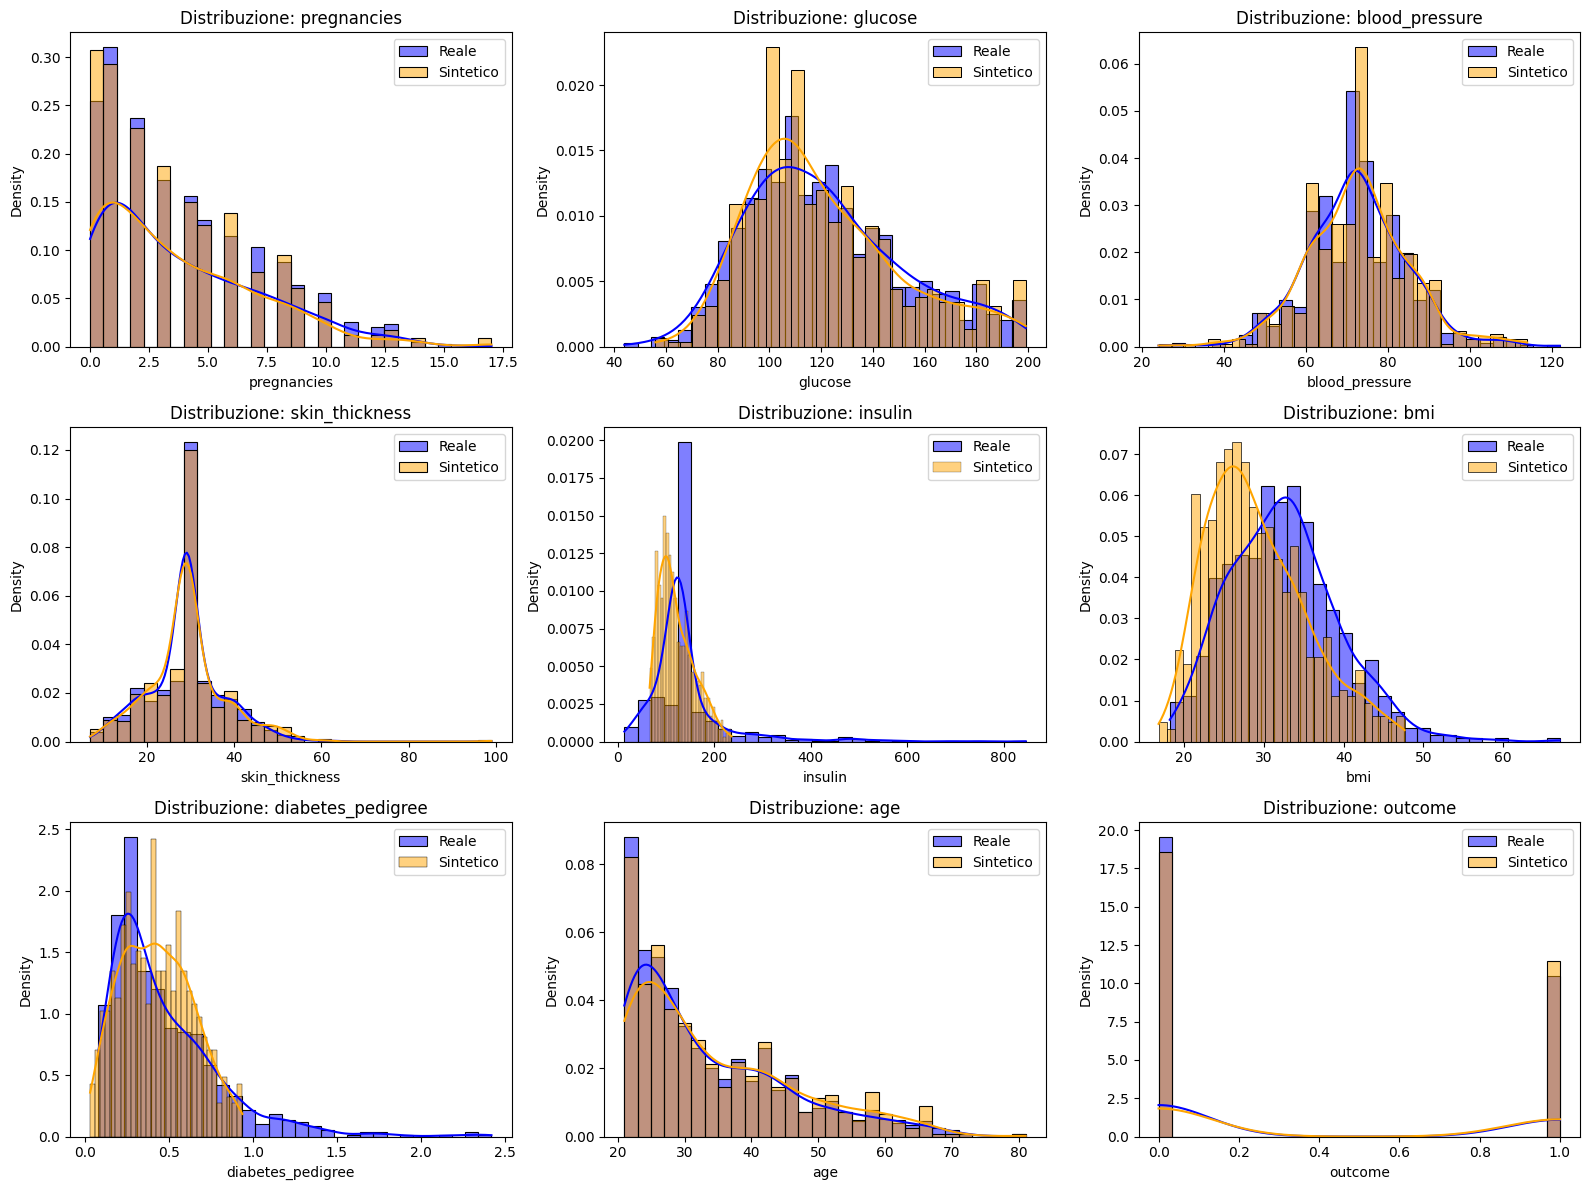


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.9118   0.2618   0.5289
glucose                        0.5151   0.6746   0.2194
blood_pressure                 0.7061   0.5549   0.7212
skin_thickness                 0.9962   0.7039   0.6686
insulin                        0.0000   0.0000   0.0006
bmi                            0.0000   0.0000   0.0454
diabetes_pedigree              0.0095   0.0030   0.0000
age                            0.5322   0.1269   0.2642
outcome                        0.8568   0.2182   0.2172

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY MODERATA DP-CTGAN =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           4.8779       1.0328
glucose                          121.6562         128.0407       6.3845
blood_pressure                    72.3867          68.8388  

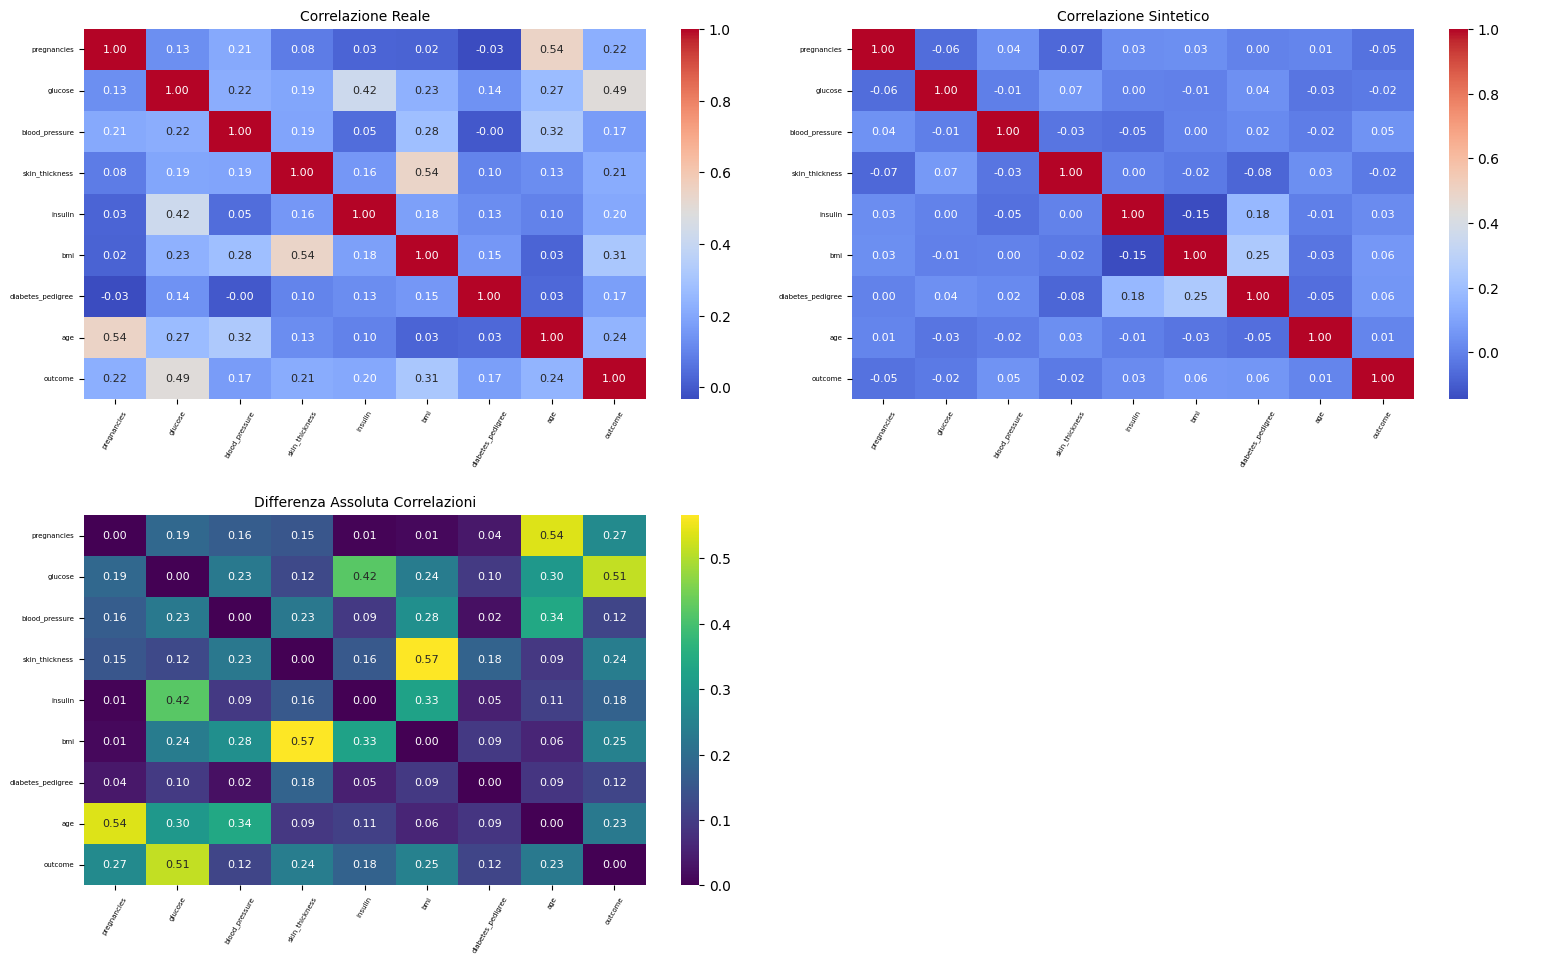

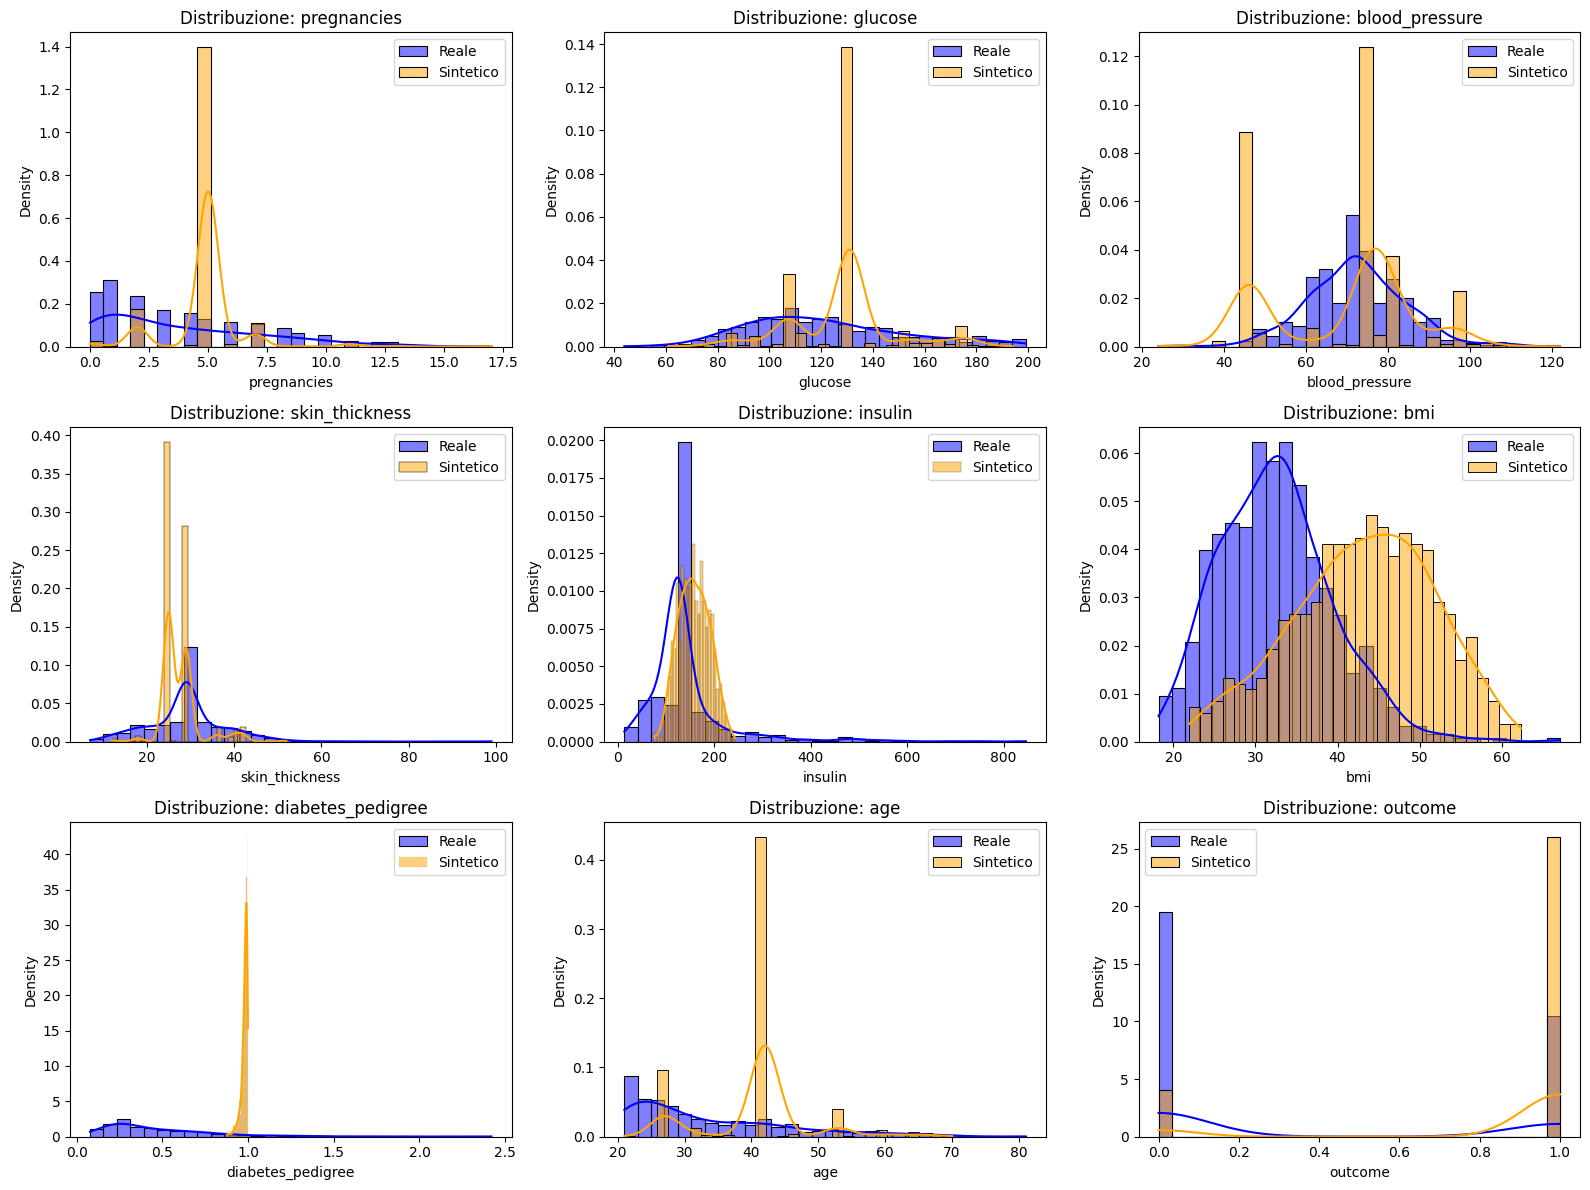


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0000   0.0000   0.0000
glucose                        0.0000   0.0000   0.0000
blood_pressure                 0.0000   0.0000   0.0000
skin_thickness                 0.0000   0.0000   0.0000
insulin                        0.0000   0.0000   0.0000
bmi                            0.0000   0.0000   0.0000
diabetes_pedigree              0.0000   0.0000   0.0000
age                            0.0000   0.0000   0.0000
outcome                        0.0000   0.0000   0.0000

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY STRONG MST =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           5.2378       1.3927
glucose                          121.6562         130.2443       8.5880
blood_pressure                    72.3867          72.0847      -0.

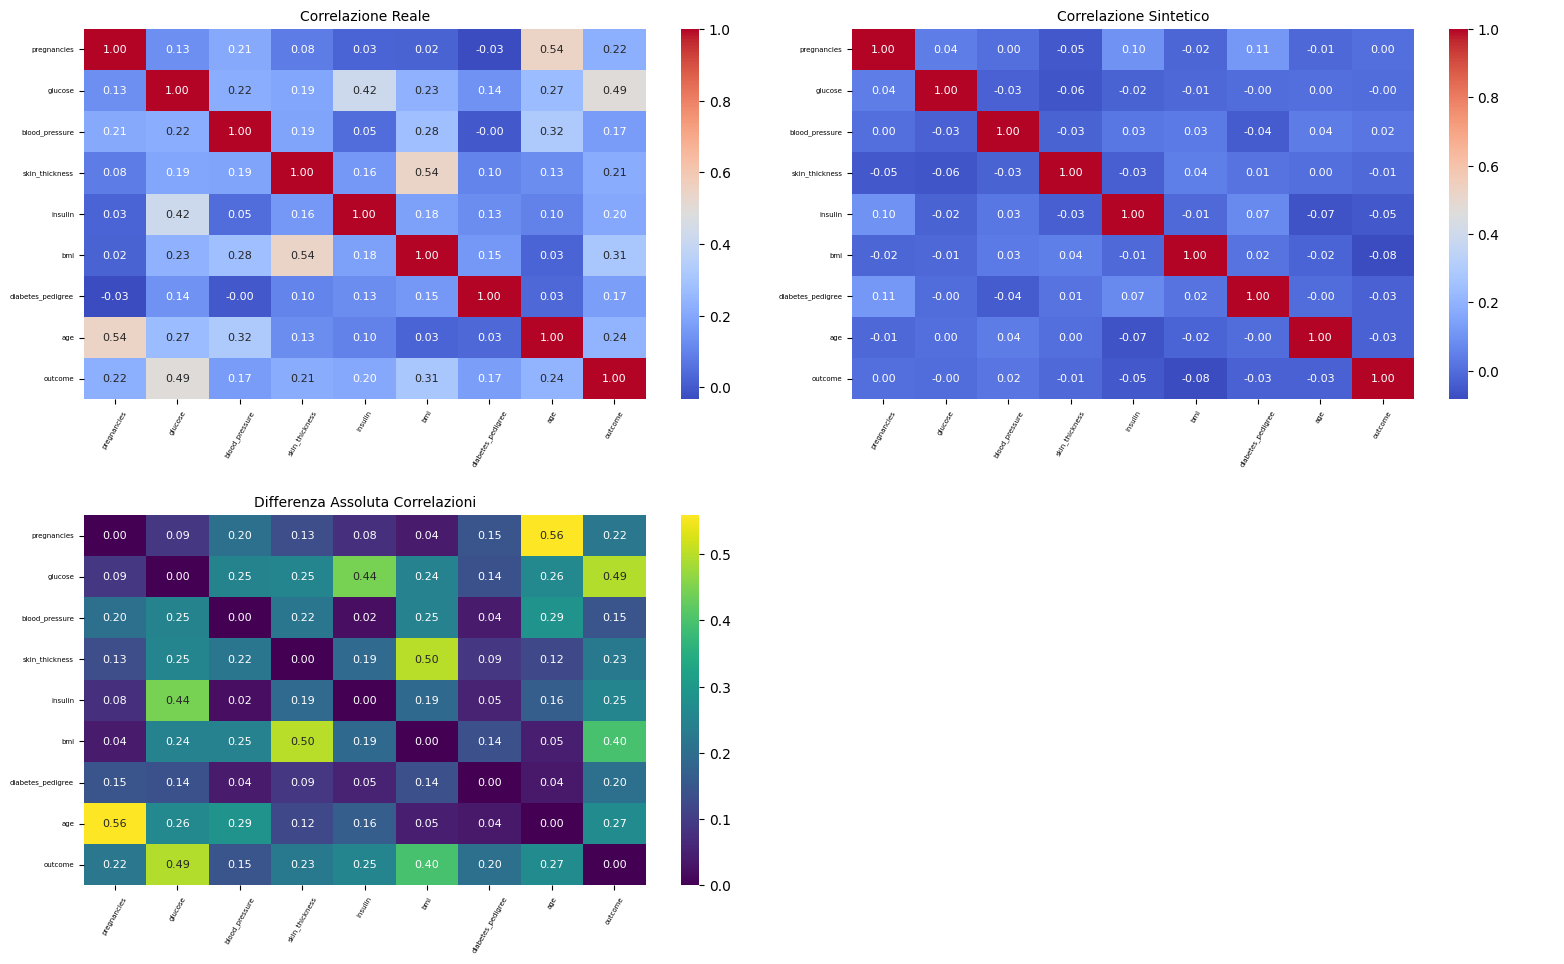

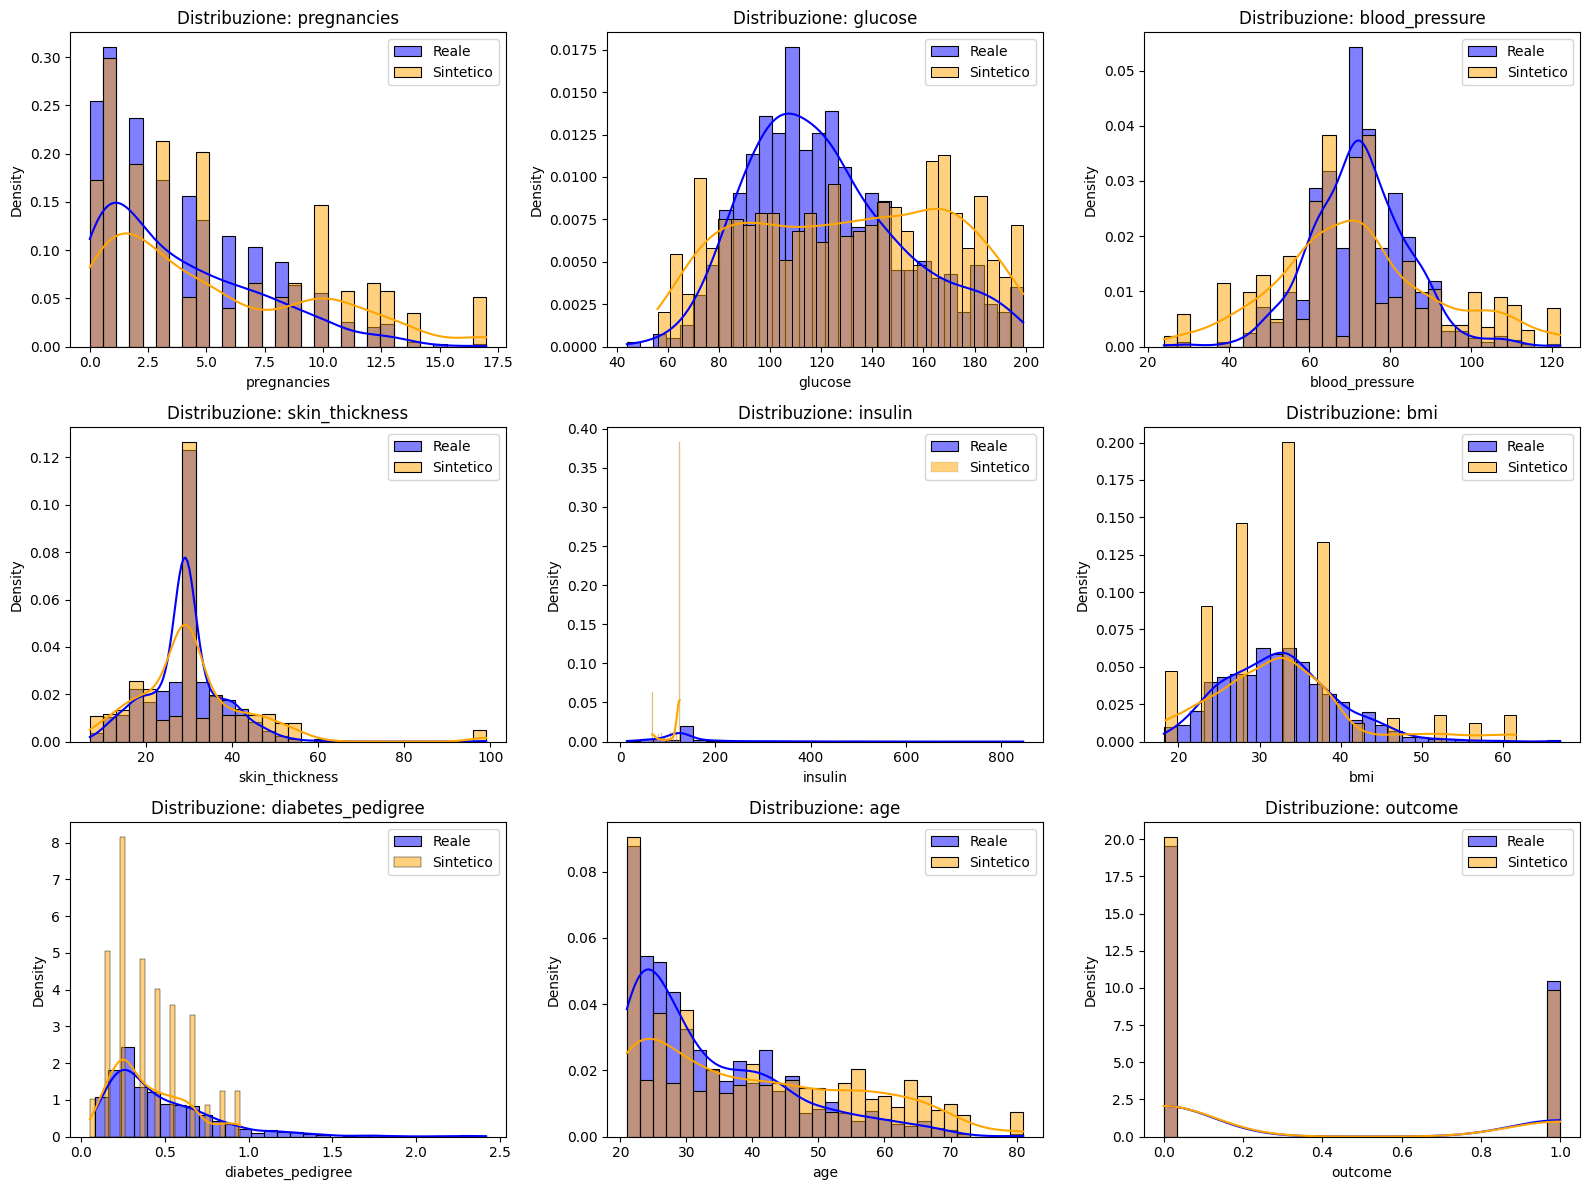


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0000   0.0000   0.0000
glucose                        0.0000   0.0000   0.0000
blood_pressure                 0.0000   0.7446   0.0000
skin_thickness                 0.0055   0.0194   0.0000
insulin                        0.0000   0.0000   0.0000
bmi                            0.0000   0.6462   0.0010
diabetes_pedigree              0.0000   0.0000   0.0000
age                            0.0000   0.0000   0.0000
outcome                        0.9987   0.4359   0.4366

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY STRONG PATE =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           6.5489       2.7038
glucose                          121.6562         128.3208       6.6646
blood_pressure                    72.3867          73.3225       0

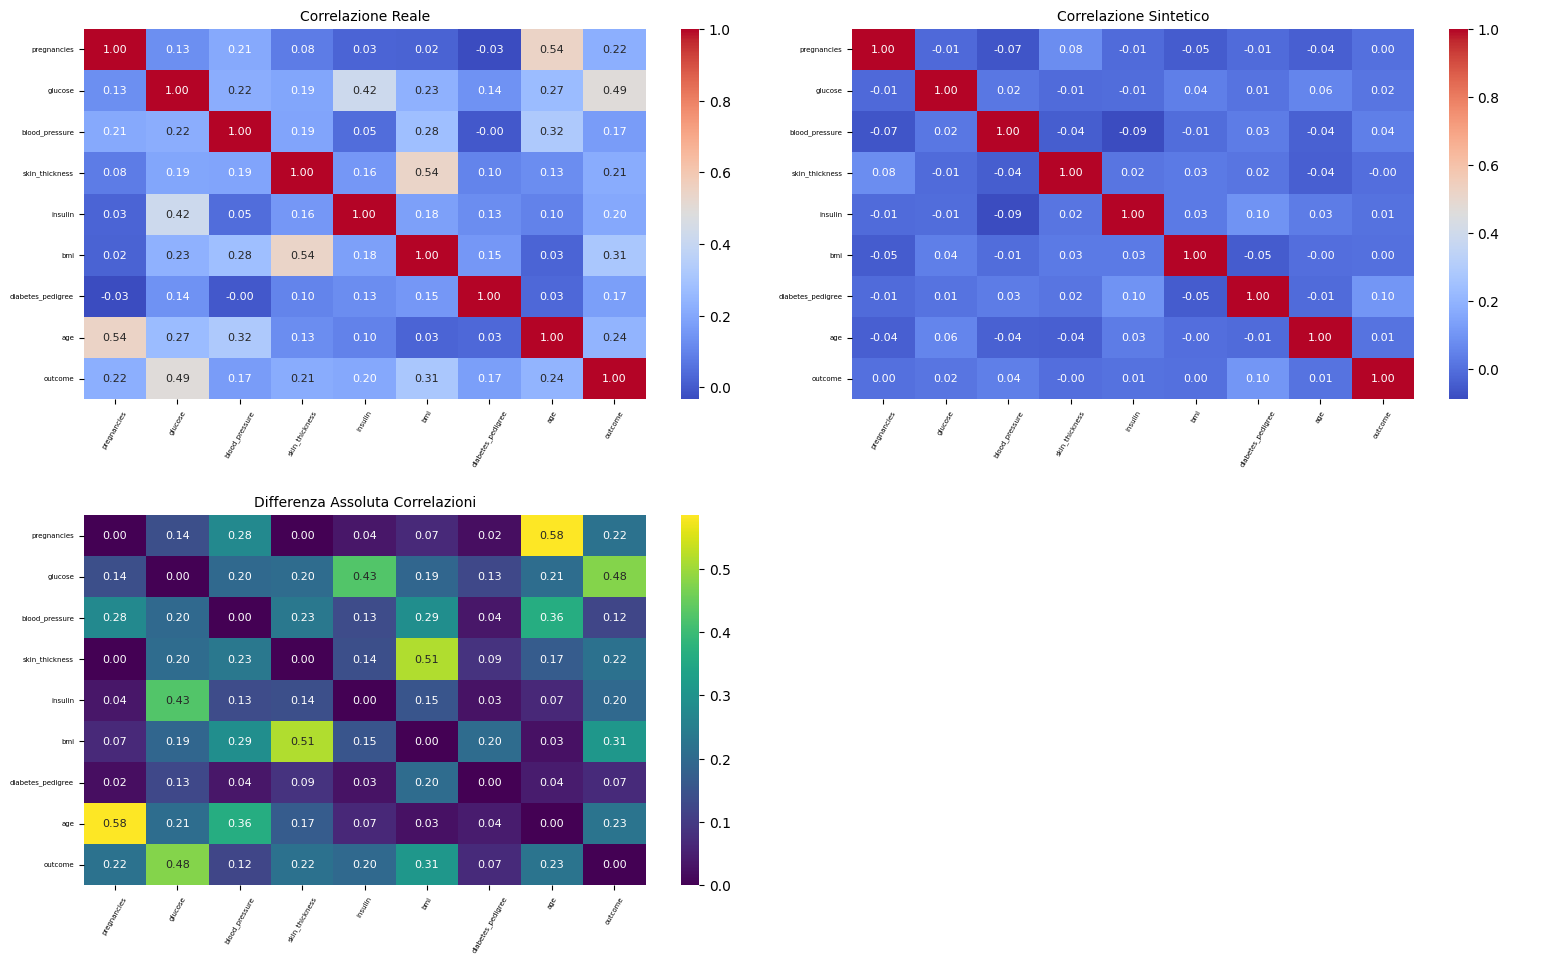

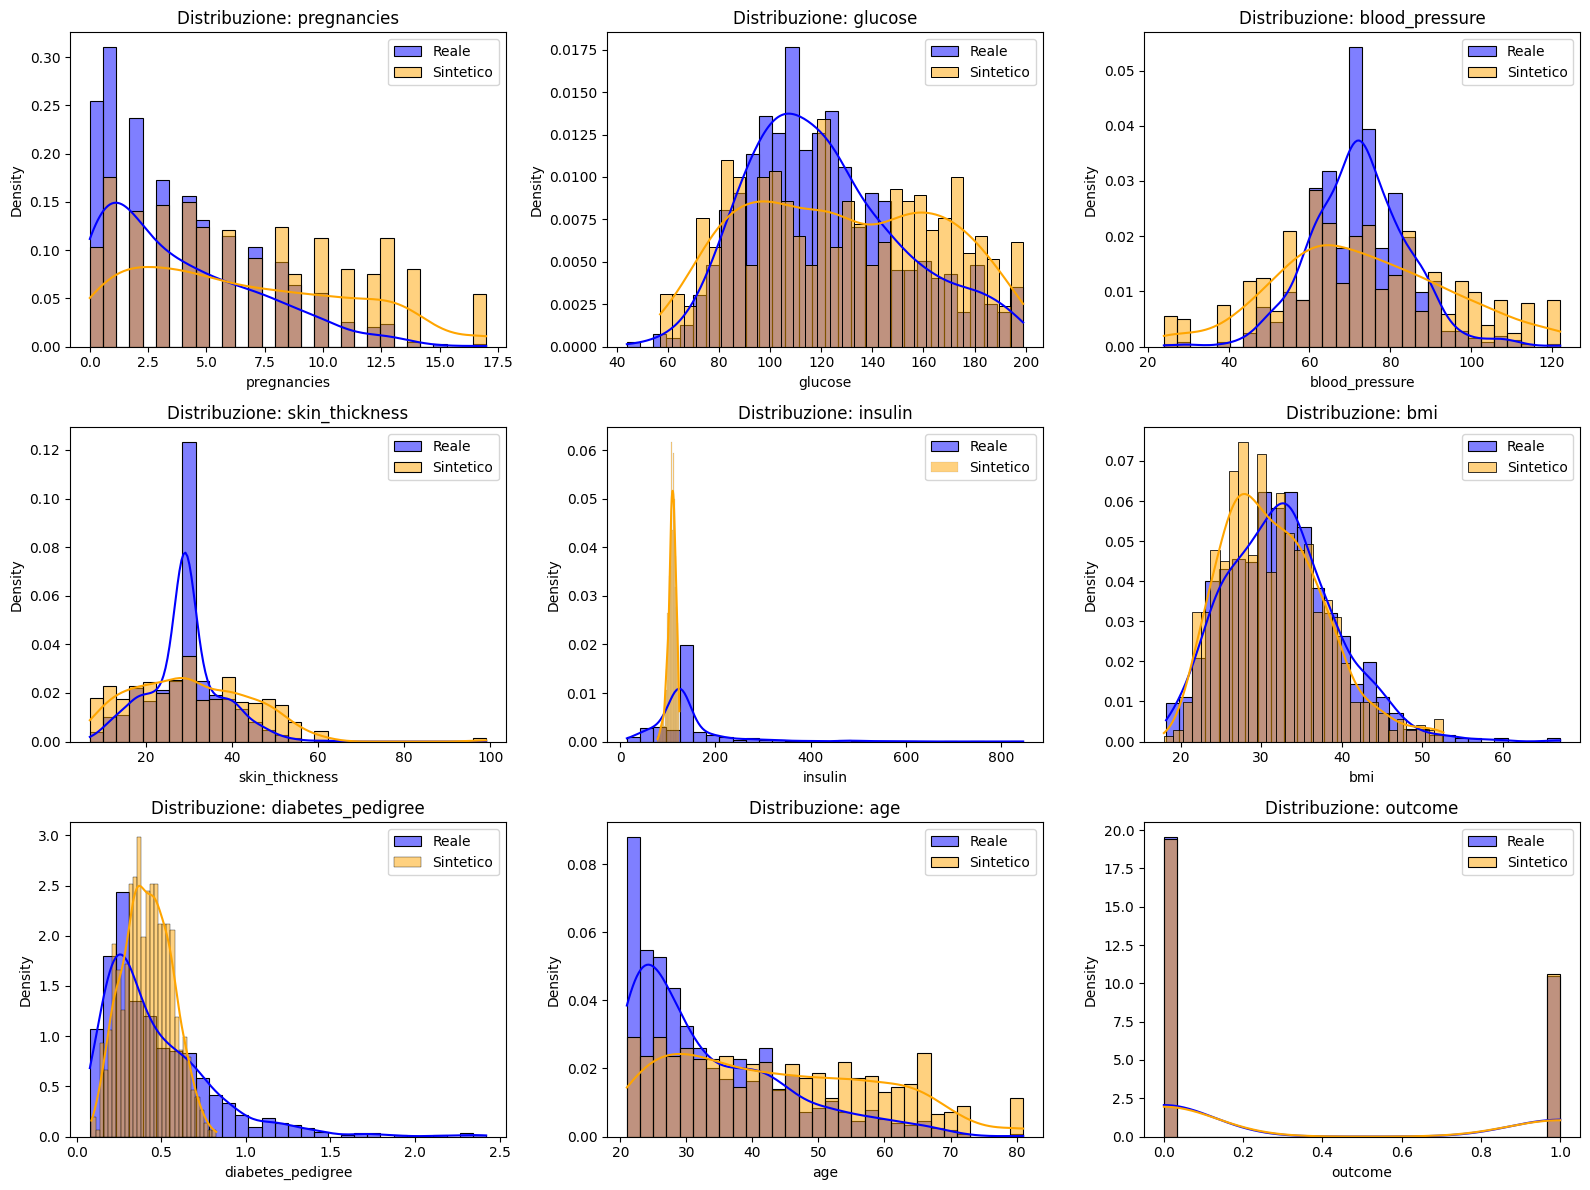


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0000   0.0000   0.0000
glucose                        0.0000   0.0004   0.0000
blood_pressure                 0.0000   0.3380   0.0000
skin_thickness                 0.0000   0.0396   0.0000
insulin                        0.0000   0.0000   0.0000
bmi                            0.0029   0.0119   0.1694
diabetes_pedigree              0.0000   0.0000   0.0000
age                            0.0000   0.0000   0.0000
outcome                        1.0000   0.8631   0.8630

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY STRONG DP-CTGAN =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451          11.2980       7.4530
glucose                          121.6562         129.7883       8.1320
blood_pressure                    72.3867          69.2557    

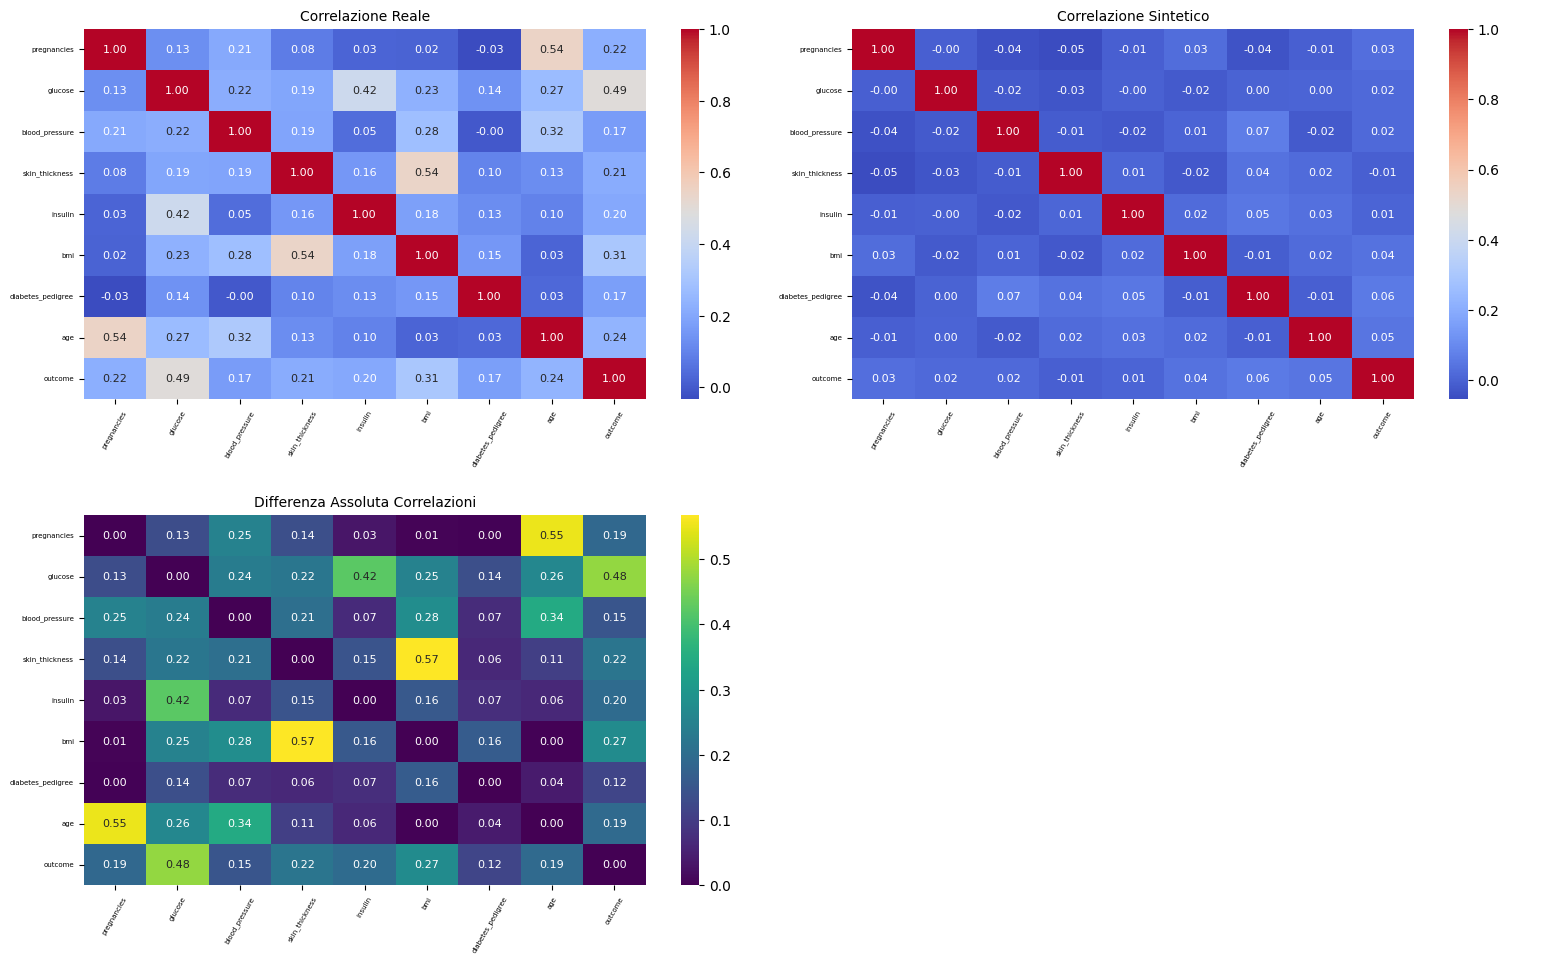

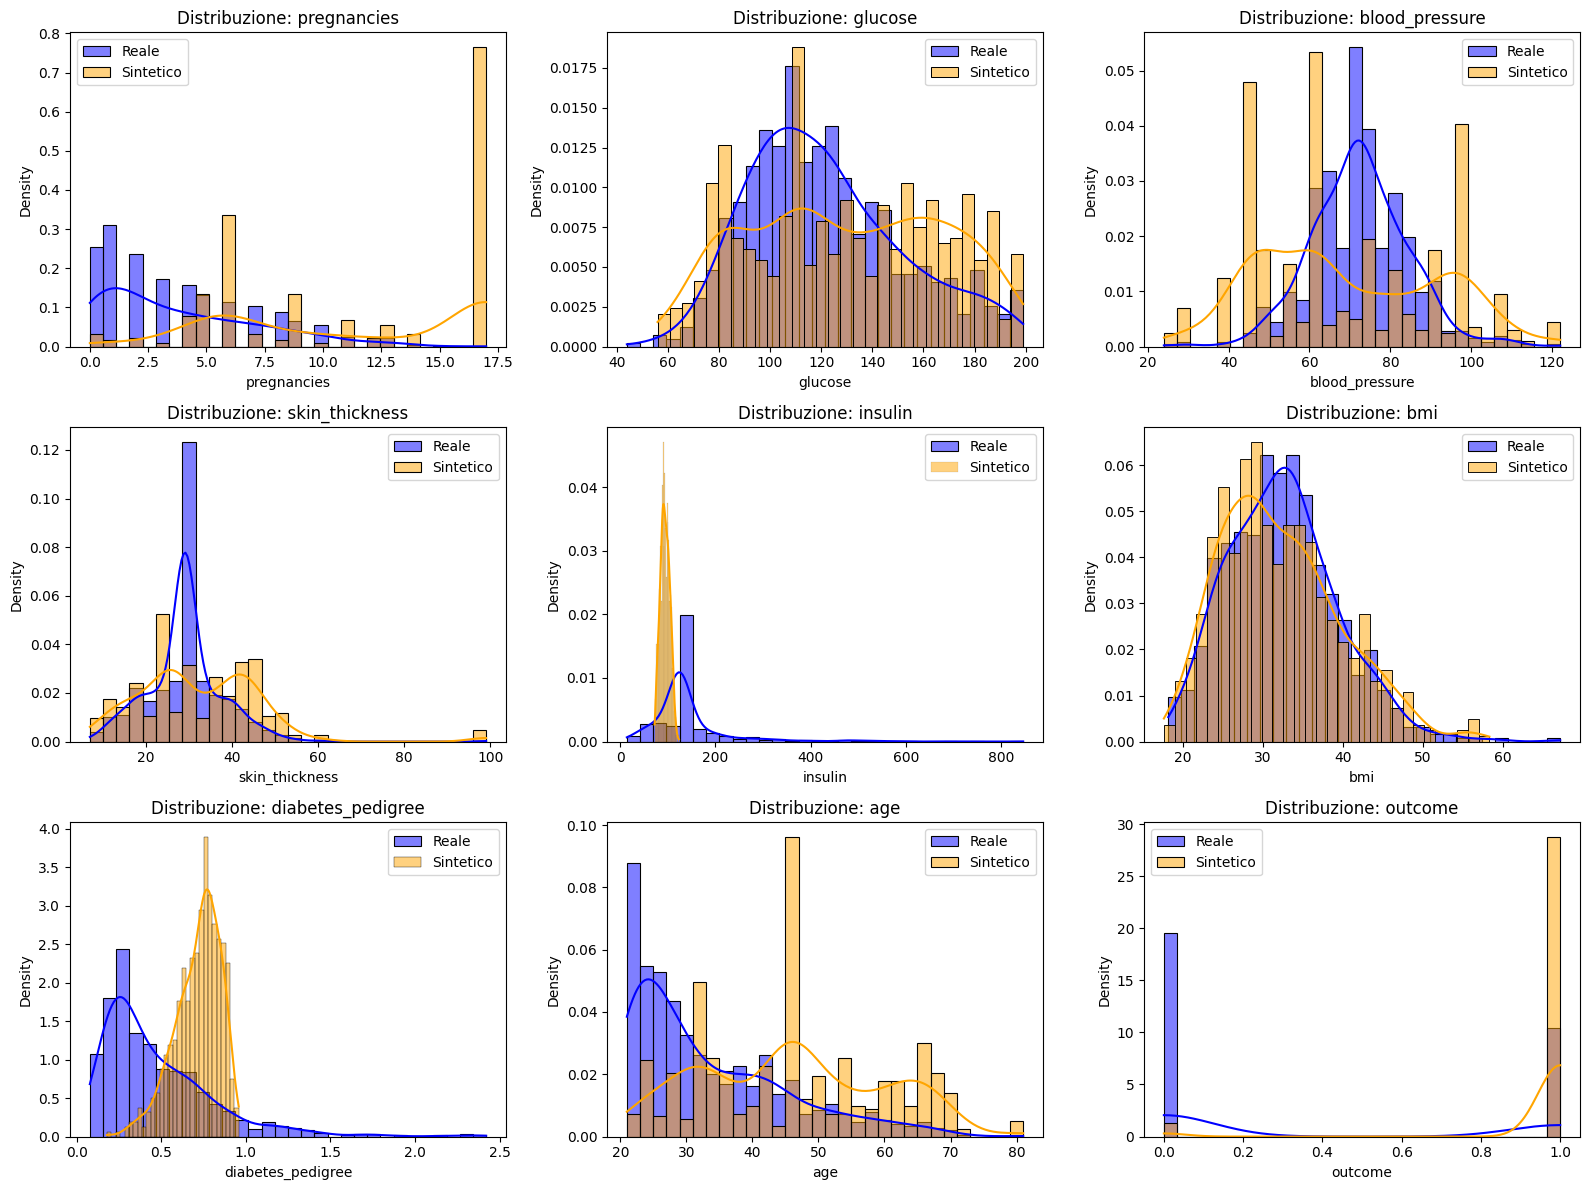


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0000   0.0000   0.0000
glucose                        0.0000   0.0000   0.0000
blood_pressure                 0.0000   0.0018   0.0000
skin_thickness                 0.0000   0.0000   0.0000
insulin                        0.0000   0.0000   0.0000
bmi                            0.0095   0.4390   0.0096
diabetes_pedigree              0.0000   0.0000   0.0000
age                            0.0000   0.0000   0.0000
outcome                        0.0000   0.0000   0.0000


In [11]:
from scipy.stats import ks_2samp, ttest_ind, levene, chi2_contingency

def somiglianza_statistica(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI SOMIGLIANZA STATISTICA: {nome} =====")

    num_cols = [col for col in real.columns if pd.api.types.is_numeric_dtype(real[col])]
    cat_cols = [col for col in real.columns if pd.api.types.is_categorical_dtype(real[col])
                or real[col].nunique() < 20]
    print("\nConfronto delle medie tra reale e sintetico:")
    print("{:<28} {:>12} {:>16} {:>12}".format('Feature', 'Mean Real', 'Mean Synthetic', 'Diff'))
    for col in num_cols:
        mean_real = real[col].mean()
        mean_synth = synth[col].mean()
        diff = mean_synth - mean_real
        print("{:<28} {:>12.4f} {:>16.4f} {:>12.4f}".format(col, mean_real, mean_synth, diff))

    # 2. Confronto MATRICE DI CORRELAZIONE
    print("\nConfronto MATRICE DI CORRELAZIONE:")
    real_corr = real[num_cols].corr()
    synth_corr = synth[num_cols].corr()
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    # Prima riga:
    sns.heatmap(real_corr, ax=axes[0, 0], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 0].set_title('Correlazione Reale', fontsize=10)
    axes[0, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 0].tick_params(axis='y', labelsize=5)
    sns.heatmap(synth_corr, ax=axes[0, 1], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 1].set_title('Correlazione Sintetico', fontsize=10)
    axes[0, 1].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 1].tick_params(axis='y', labelsize=5)
    # Seconda riga:
    axes[1, 1].axis('off')
    sns.heatmap(abs(real_corr - synth_corr), ax=axes[1, 0], cmap='viridis', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[1, 0].set_title('Differenza Assoluta Correlazioni', fontsize=10)
    axes[1, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[1, 0].tick_params(axis='y', labelsize=5)
    plt.tight_layout(pad=2)
    plt.show()

    # 3. Confronto DISTRIBUZIONI
    num_per_row = 3
    num_cols_total = len(num_cols)
    num_rows = int(np.ceil(num_cols_total / num_per_row))
    fig_width = 16
    fig_height = 4 * num_rows
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.histplot(real[col], color='blue', label='Reale', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        sns.histplot(synth[col], color='orange', label='Sintetico', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        ax.set_title(f'Distribuzione: {col}')
        ax.set_ylabel('Density')
        ax.set_xlabel(col)
        ax.legend()
    for ax in axes[len(num_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

    # 4. TEST STATISTICI STANDARD
    print("\nTest statistici standard:")

    # --- Numeriche ---
    print("\nFeature numeriche:")
    print("{:<28} {:>8} {:>8} {:>8}".format('Feature', 'KS-p', 't-p', 'Levene-p'))
    for col in num_cols:
        try:
            ks_p = ks_2samp(real[col], synth[col]).pvalue
            t_p = ttest_ind(real[col], synth[col], equal_var=False).pvalue
            lev_p = levene(real[col], synth[col]).pvalue
            print("{:<28} {:>8.4f} {:>8.4f} {:>8.4f}".format(col, ks_p, t_p, lev_p))
        except Exception as e:
            print(f"{col}: Errore nel calcolo dei test: {e}")

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA MST", synthetic_mod_mst, metadata_mod_mst),
    ("PRIVACY MODERATA PATE", synthetic_mod_pate, metadata_mod_pate),
    ("PRIVACY MODERATA DP-CTGAN", synthetic_mod_dpctgan, metadata_mod_dpctgan),
    ("PRIVACY STRONG MST", synthetic_strong_mst, metadata_strong_mst),
    ("PRIVACY STRONG PATE", synthetic_strong_pate, metadata_strong_pate),
    ("PRIVACY STRONG DP-CTGAN", synthetic_strong_dpctgan, metadata_strong_dpctgan)
]

for nome, synth_df, meta in datasets_sintetici:
    somiglianza_statistica(df, synth_df, meta, nome)


### **VALUTARE UTILITA' PER LA RICERCA**: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout

**TRINING DEI MODELLI CON I DIVERSI DATASET SINTETICI GENERATI (NO PRIVACY, MODERATA, STRONG)**

In [12]:
def train_and_save_xgboost(synthetic_df, privacy_label, model_params=None, target_col="outcome"):
    """
    Allena un modello XGBoost su un dataset sintetico e lo salva su disco.

    Args:
        synthetic_df: pd.DataFrame, dati sintetici da usare (features + target).
        privacy_label: str, etichetta privacy usata nel nome file ("noprivacy", "mod", "strong").
        model_params: dict, parametri opzionali per XGBClassifier.
        target_col: str, nome della colonna target (default: "outcome").

    Returns:
        Il modello allenato.
    """
    if model_params is None:
        # Parametri di default robusti
        model_params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            random_state=42
        )
    X = synthetic_df.drop(columns=[target_col])
    y = synthetic_df[target_col]
    model = XGBClassifier(**model_params)
    model.fit(X, y)
    filename = f'xgboost_model_{privacy_label}.pkl'
    joblib.dump(model, filename)
    print(f"Modello XGBoost addestrato e salvato: {filename}")
    return model

# Allena 3 modelli con diversi i dataset sintetici di input
print("Training modello con dataset NO PRIVACY...")
model_noprivacy = train_and_save_xgboost(synthetic_noprivacy, "noprivacy")
print("Training modelli con dataset PRIVACY MODERATA...")
model_modprivacy_mst = train_and_save_xgboost(synthetic_mod_mst, "modprivacy_mst")
model_modprivacy_pate = train_and_save_xgboost(synthetic_mod_pate, "modprivacy_pate")
model_modprivacy_dpctgan = train_and_save_xgboost(synthetic_mod_dpctgan, "modprivacy_dpctgan")
print("Training modelli con dataset PRIVACY STRONG...")
model_strongprivacy_mst = train_and_save_xgboost(synthetic_strong_mst, "strongprivacy_mst")
model_strongprivacy_pate = train_and_save_xgboost(synthetic_strong_pate, "strongprivacy_pate")
model_strongprivacy_dpctgan = train_and_save_xgboost(synthetic_strong_dpctgan, "strongprivacy_dpctgan")



Training modello con dataset NO PRIVACY...
Modello XGBoost addestrato e salvato: xgboost_model_noprivacy.pkl
Training modelli con dataset PRIVACY MODERATA...
Modello XGBoost addestrato e salvato: xgboost_model_modprivacy_mst.pkl
Modello XGBoost addestrato e salvato: xgboost_model_modprivacy_pate.pkl
Modello XGBoost addestrato e salvato: xgboost_model_modprivacy_dpctgan.pkl
Training modelli con dataset PRIVACY STRONG...
Modello XGBoost addestrato e salvato: xgboost_model_strongprivacy_mst.pkl
Modello XGBoost addestrato e salvato: xgboost_model_strongprivacy_pate.pkl
Modello XGBoost addestrato e salvato: xgboost_model_strongprivacy_dpctgan.pkl


**TEST DEI MODELLI SU DATI REALI HOLDOUT**

In [13]:
results = []

def test_xgboost_model(model, X_real, y_real, privacy_label):
    y_pred = model.predict(X_real)
    y_prob = model.predict_proba(X_real)[:, 1]

    acc = accuracy_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)

    print(f"\nPerformance del modello allenato su dati {privacy_label.upper()} e testato su Dataset Reale di Holdout")
    print("Accuracy:", acc)
    print("ROC-AUC:", auc)
    print("\nClassification Report:")
    report = classification_report(y_real, y_pred, output_dict=True)
    print(classification_report(y_real, y_pred))

    # Salva tutte le info
    results.append({
        "privacy_level": privacy_label,
        "accuracy": acc,
        "roc_auc": auc,
        "precision_0": report["0"]["precision"],
        "recall_0": report["0"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "precision_1": report["1"]["precision"],
        "recall_1": report["1"]["recall"],
        "f1_1": report["1"]["f1-score"],
    })


# Separa feature e target nel dataset holdout (lo fai una sola volta)
X_real = holdout_df.drop(columns=["outcome"])
y_real = holdout_df["outcome"]

print("Distribuzione outcome nel test set:")
print(y_real.value_counts(normalize=True))

# Usa la funzione per tutti i modelli
test_xgboost_model(model_noprivacy, X_real, y_real, "no privacy")
test_xgboost_model(model_modprivacy_mst, X_real, y_real, "moderate privacy")
test_xgboost_model(model_modprivacy_pate, X_real, y_real, "moderate privacy")
test_xgboost_model(model_modprivacy_dpctgan, X_real, y_real, "moderate privacy")
test_xgboost_model(model_strongprivacy_mst, X_real, y_real, "strong privacy")
test_xgboost_model(model_strongprivacy_pate, X_real, y_real, "strong privacy")
test_xgboost_model(model_strongprivacy_dpctgan, X_real, y_real, "strong privacy")
df_metrics = pd.DataFrame(results)
df_metrics.to_csv("model_performance.csv", index=False)


Distribuzione outcome nel test set:
outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64

Performance del modello allenato su dati NO PRIVACY e testato su Dataset Reale di Holdout
Accuracy: 0.6298701298701299
ROC-AUC: 0.7035185185185185

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       100
           1       0.48      0.59      0.53        54

    accuracy                           0.63       154
   macro avg       0.61      0.62      0.61       154
weighted avg       0.65      0.63      0.64       154


Performance del modello allenato su dati MODERATE PRIVACY e testato su Dataset Reale di Holdout
Accuracy: 0.6493506493506493
ROC-AUC: 0.6548148148148148

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       100
           1       0.50      0.26      0.34        54

    accuracy                           0.65       154


### **VALUTARE LA PRIVACY**: implementare Membership Inference Attack per misurare la perdita di informazioni

In [14]:
# =======================Membership Inference Attack =======================
"""
Per ogni generatore sintetico (no-privacy, privacy moderata, privacy strong) costruisce feature che misurano quanto ogni record reale è
ben rappresentato dal sintetico (distanze k-NN, densità locale, errore di ricostruzione), addestra un classificatore XGBoost che
predice se un record appartiene al training set (membro) o al holdout (non-membro) e infine riporta accuratezza e AUC dell’attaccante.
   - Membri = diabetes_train.csv
   - Non-membri = diabetes_holdout
   - Feature MIA: k-NN distance + local density + recon error
   - Attaccante: classificatore supervisionato
"""

import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBRegressor, XGBClassifier

# -----------------------------------------------------
# 0. Carica dataset reali e sintetici da CSV
# -----------------------------------------------------
df_real_train   = pd.read_csv("dataset/real/diabetes_train.csv")
df_real_holdout = pd.read_csv("dataset/real/diabetes_holdout.csv")

synthetic_noprivacy = pd.read_csv("dataset/synthetic/synthetic_no_privacy.csv")

synthetic_mod       = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata_mst.csv")
synthetic_strong    = pd.read_csv("dataset/synthetic/synthetic_privacy_strong_mst.csv")
"""
synthetic_mod       = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata_pate.csv")
synthetic_strong    = pd.read_csv("dataset/synthetic/synthetic_privacy_strong_pate.csv")

synthetic_mod       = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata_dpctgan.csv")
synthetic_strong    = pd.read_csv("dataset/synthetic/synthetic_privacy_strong_dpctgan.csv")
"""
target_col = "outcome"
feature_cols = [c for c in df_real_train.columns if c != target_col]

# ============================================================
# 1. Feature MIA: k-NN distance + local density
# ============================================================
def compute_nn_and_density(real_df, synth_df, feature_cols, k=5, radius=0.5):
    """
    Per ogni record reale calcola:
      - dist_min: distanza al sintetico più vicino
      - dist_mean_k: media delle prime k distanze
      - density_r: numero di sintetici entro un raggio r (normalizzato)
    """
    X_real = real_df[feature_cols].values
    X_synth = synth_df[feature_cols].values

    # Standardizza
    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    # k-NN distances
    knn = NearestNeighbors(n_neighbors=k, metric="euclidean")
    knn.fit(X_synth_std)
    dists, _ = knn.kneighbors(X_real_std)
    dist_min = dists[:, 0]
    dist_mean_k = dists.mean(axis=1)

    # Local density entro r
    nn_radius = NearestNeighbors(radius=radius, metric="euclidean")
    nn_radius.fit(X_synth_std)
    neigh_idx = nn_radius.radius_neighbors(X_real_std, return_distance=False)
    density_r = np.array([len(idx) for idx in neigh_idx], dtype=float)
    density_r /= (density_r.max() + 1e-8)  # normalizza

    feats = np.vstack([dist_min, dist_mean_k, density_r]).T
    return feats

# ============================================================
# 2. Feature MIA: errore di ricostruzione (model-based)
# ============================================================
def compute_reconstruction_error(real_df, synth_df, feature_cols):
    """
    Serve a misurare quanto un modello addestrato sui dati sintetici riesce a predire le feature dei record reali (errore di ricostruzione medio).
    Se il generatore non rappresenta bene x, l’errore sarà alto.

    Allena un regressore XGBRegressor su sintetico per predire ogni feature
    a partire dalle altre. Per ogni record reale calcola l'errore medio
    di ricostruzione sulle feature.
    """
    X_synth = synth_df[feature_cols].values
    X_real  = real_df[feature_cols].values

    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    n_features = len(feature_cols)
    errors = np.zeros((X_real_std.shape[0], n_features))

    for j in range(n_features):
        idx_other = [i for i in range(n_features) if i != j]

        X_tr = X_synth_std[:, idx_other]
        y_tr = X_synth_std[:, j]

        model = XGBRegressor(
            n_estimators=150,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            n_jobs=1
        )
        model.fit(X_tr, y_tr)

        X_te = X_real_std[:, idx_other]
        y_te = X_real_std[:, j]
        y_pred = model.predict(X_te)

        errors[:, j] = (y_te - y_pred) ** 2

    mse_per_record = errors.mean(axis=1)
    return mse_per_record.reshape(-1, 1)  # (n,1)

# ============================================================
# 3. Costruzione dataset MIA
# ============================================================
def build_mia_dataset(real_train, real_holdout, synth_df):
    """
    Costruisce il dataset usato dall’attaccante, con etichette y=1 per membri (records di diabetes_train) e y=0 per non-membri (records di diabetes_holdout).

    Vettore di feature per ciascun record reale x:
      phi(x) = [dist_min, dist_mean_k, density_r, recon_error]
    calcolate rispetto a synth_df.
    """
    # Membri
    feats_nn_train  = compute_nn_and_density(real_train, synth_df, feature_cols,
                                             k=5, radius=0.5)
    feats_rec_train = compute_reconstruction_error(real_train, synth_df, feature_cols)
    X_mem = np.hstack([feats_nn_train, feats_rec_train])
    y_mem = np.ones(len(real_train), dtype=int)

    # Non-membri
    feats_nn_hold  = compute_nn_and_density(real_holdout, synth_df, feature_cols,
                                            k=5, radius=0.5)
    feats_rec_hold = compute_reconstruction_error(real_holdout, synth_df, feature_cols)
    X_non = np.hstack([feats_nn_hold, feats_rec_hold])
    y_non = np.zeros(len(real_holdout), dtype=int)

    X = np.vstack([X_mem, X_non])
    y = np.concatenate([y_mem, y_non])

    return X, y

# ============================================================
# 4. Attaccante supervisionato (XGBoost)
# ============================================================
def run_mia_attack(X, y, test_size=0.3, seed=42):
    """
    Addestrare l’attaccante (classificatore XGBoost) sulle feature MIA e valutare accuracy e AUC.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr)
    X_te_std = scaler.transform(X_te)

    attacker = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=seed,
        n_jobs=1
    )
    attacker.fit(X_tr_std, y_tr)

    proba = attacker.predict_proba(X_te_std)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    auc = roc_auc_score(y_te, proba)

    return acc, auc

# ============================================================
# 5. Esegui il MIA per ciascun generatore
# ============================================================
results = {}

X_ctgan, y_ctgan = build_mia_dataset(df_real_train, df_real_holdout, synthetic_noprivacy)
acc_ctgan, auc_ctgan = run_mia_attack(X_ctgan, y_ctgan)
results["CTGAN_no_privacy"] = (acc_ctgan, auc_ctgan)

X_dp6, y_dp6 = build_mia_dataset(df_real_train, df_real_holdout, synthetic_mod)
acc_dp6, auc_dp6 = run_mia_attack(X_dp6, y_dp6)
results["Privacy moderata"] = (acc_dp6, auc_dp6)

X_dp2, y_dp2 = build_mia_dataset(df_real_train, df_real_holdout, synthetic_strong)
acc_dp2, auc_dp2 = run_mia_attack(X_dp2, y_dp2)
results["Privacy strong"] = (acc_dp2, auc_dp2)

# ============================================================
# 6. Risultati
# ============================================================
print("\n=== Membership Inference Attack ===")
print(f"{'Generatore':20s} {'ACC':>8s} {'AUC':>8s} {'PrivacyLoss':>14s}")

privacy_results = {}

for name, (acc, auc) in results.items():
    privacy_loss = auc - 0.5          # perdita di info assoluta
    privacy_adv  = 2 * (auc - 0.5)    # vantaggio normalizzato in [0,1]
    privacy_results[name] = {
        "acc": acc,
        "auc": auc,
        "privacy_loss": privacy_loss,
        "privacy_adv": privacy_adv
    }
    print(f"{name:20s} {acc:8.3f} {auc:8.3f} {privacy_loss:14.3f}")

# Trasforma i risultati in DataFrame
df_privacy = pd.DataFrame.from_dict(privacy_results, orient="index")
df_privacy.index.name = "Generatore"

# Salva in CSV
df_privacy.to_csv("mia_results_summary.csv")



=== Membership Inference Attack ===
Generatore                ACC      AUC    PrivacyLoss
CTGAN_no_privacy        0.771    0.490         -0.010
Privacy moderata        0.779    0.562          0.062
Privacy strong          0.758    0.498         -0.002


### **VISUALIZZARE IL TRADE-OFF**: tracciare livello di privacy vs. metriche di utilità per identificare il bilanciamento ottimale

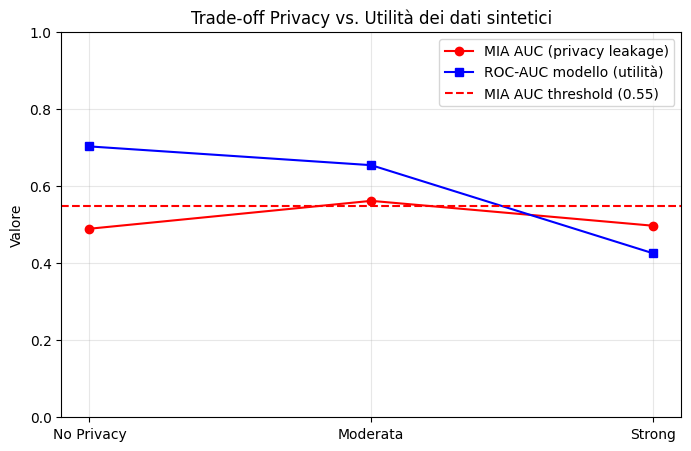

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i CSV
mia_df = pd.read_csv("mia_results_summary.csv")
model_df = pd.read_csv("model_performance.csv")

# Ordina livelli di privacy
privacy_levels = ["CTGAN_no_privacy", "Privacy moderata", "Privacy strong"]
x_labels = ["No Privacy", "Moderata", "Strong"]

# Allinea dati
mia_auc = [mia_df[mia_df['Generatore'] == lvl]['auc'].values[0] for lvl in privacy_levels]
model_roc = [
    model_df[model_df['privacy_level'].str.contains("no privacy")]['roc_auc'].values[0],
    model_df[model_df['privacy_level'].str.contains("moderate")]['roc_auc'].values[0],
    model_df[model_df['privacy_level'].str.contains("strong")]['roc_auc'].values[0]
]

# Soglia MIA per considerare privacy non passata
mia_threshold = 0.55

# Crea il grafico
plt.figure(figsize=(8,5))
plt.plot(x_labels, mia_auc, 'o-', color='red', label='MIA AUC (privacy leakage)')
plt.plot(x_labels, model_roc, 's-', color='blue', label='ROC-AUC modello (utilità)')

# Linea tratteggiata soglia MIA
plt.axhline(y=mia_threshold, color='red', linestyle='--', label=f'MIA AUC threshold ({mia_threshold})')

plt.ylim(0,1)
plt.ylabel("Valore")
plt.title("Trade-off Privacy vs. Utilità dei dati sintetici")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
